In [155]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xml.etree.ElementTree as ET

from collections import defaultdict, Counter

In [156]:
sns.set(style="whitegrid")

# ETS allowance exploration

## Load data

In [157]:
YEARS = ['2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']

In [158]:
tree = ET.parse('data/france_allowances_phase3.xml')
root = tree.getroot()

## Data exploration

In [5]:
installationNodes = root.findall(".//AllocationTableOperatorInformationPublic/AllocationTableOperatorInformation")

In [6]:
rows = []
for installationNode in installationNodes:
    row = [
        installationNode.find('Status').text,
        installationNode.find('AccountHolderName').text,
        installationNode.find('InstallationName').text
    ]
    for year in YEARS:
        try:
            row.append(int(installationNode.find('allocation'+year).text))
        except:
            row.append(None)
    rows.append(row)

In [7]:
data = pd.DataFrame(
    rows,
    columns=[
        'status',
        'accountHolderName',
        'installationName',
        '2013',
        '2014',
        '2015',
        '2016',
        '2017',
        '2018',
        '2019',
        '2020'
    ]
)

In [8]:
data.head()

,status,accountHolderName,installationName,2013,2014,2015,2016,2017,2018,2019,2020
0,Active,NESTLE FRANCE SAS,NESTLE FRANCE - Boué,18618.0,16661.0,22459.0,22046.0,21628.0,21206,20779,20351
1,Active,TEREOS FRANCE,Sucrerie de Bucy,84637.0,83167.0,81680.0,80177.0,78659.0,77125,75572,74013
2,Active,WEPA GREENFIELD SAS,WEPA GREENFIELD SAS,4599.0,4519.0,4438.0,4356.0,4274.0,4190,4106,4021
3,Permit Revoked,ARKEMA FRANCE,ARKEMA FRANCE - Usine de Chauny,64889.0,63762.0,0.0,0.0,0.0,0,0,0
4,Active,VERALLIA FRANCE,VERALLIA FRANCE - Vauxrot,58178.0,57167.0,56145.0,55113.0,54068.0,53014,51947,50875


### Number installations

In [99]:
data.shape

(1151, 11)

### Number of account holders

In [37]:
installationsPerAccount = data.groupby(['accountHolderName'])['installationName'].count()
installationsPerAccount.shape

(702,)

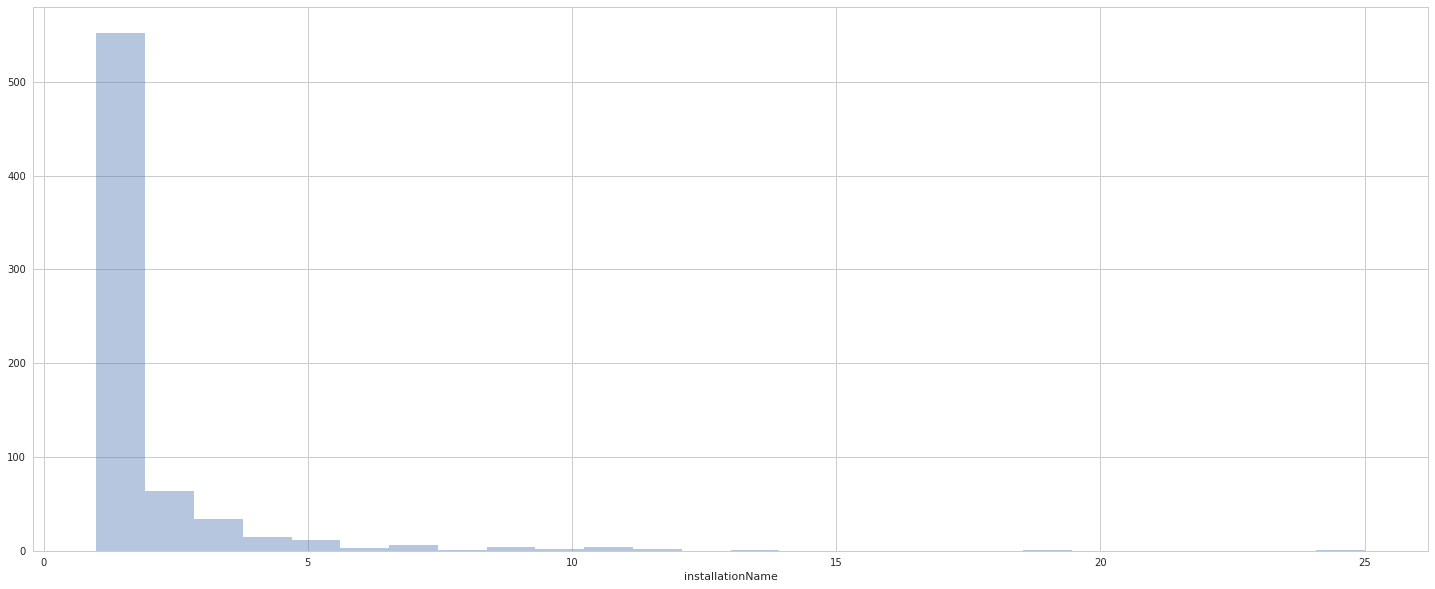

In [17]:
plt.figure(figsize=(25,10))
sns.distplot(installationsPerAccount, kde=False)

In [21]:
installationsPerAccount[installationsPerAccount > 1].sort_values(ascending=False)

accountHolderName
 DALKIA                                             25
 ENGIE ENERGIE SERVICES                             19
 GRTGAZ                                             13
 EDILIANS                                           12
 TEREOS FRANCE                                      12
 CRISTAL UNION                                      11
 LAFARGEHOLCIM CIMENTS                              11
 WIENERBERGER                                       11
 G'SELL                                             11
 ARKEMA FRANCE                                      10
 SVD 17                                             10
 OI FRANCE SAS                                       9
 Manufacture Française des Pneumatiques Michelin     9
 BOUYER LEROUX                                       9
 CIMENTS CALCIA                                      9
 TOTAL RAFFINAGE FRANCE                              8
 STORENGY FRANCE                                     7
 SOLVAY OPERATIONS FRANCE                      

#### Analysing account name splitting for similar companies

In [33]:
installationsPerAccount[installationsPerAccount.index.str.contains('NESTLE')]

accountHolderName
 NESTLE FRANCE SAS               2
 NESTLE GRAND FROID              1
 NESTLE PURINA PETCARE FRANCE    2
Name: installationName, dtype: int64

In [34]:
installationsPerAccount[installationsPerAccount.index.str.contains('SOLVAY')]

accountHolderName
 SOLVAY ENERGY SERVICES      2
 SOLVAY OPERATIONS FRANCE    7
Name: installationName, dtype: int64

In [36]:
installationsPerAccount[installationsPerAccount.index.str.contains('ARCELOR')]

accountHolderName
 ARCELORMITTAL ATLANTIQUE ET LORRAINE    5
 ARCELORMITTAL CONSTRUCTION France       2
 ARCELORMITTAL GANDRANGE                 1
 ARCELORMITTAL MEDITERRANEE              1
Name: installationName, dtype: int64

In [32]:
installationsPerAccount[installationsPerAccount.index.str.contains('TOTAL')]

accountHolderName
 TOTAL E&P France               1
 TOTAL PETROCHEMICALS FRANCE    2
 TOTAL RAFFINAGE FRANCE         8
Name: installationName, dtype: int64

### Proportion of None or zero

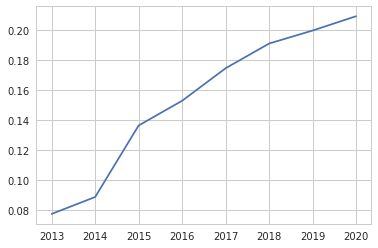

In [100]:
p = [data[(data[year] == 0) | (data[year].isnull())].shape[0] / data.shape[0] for year in YEARS]
plt.plot(YEARS, p)
plt.show()

### Proportion of statuses

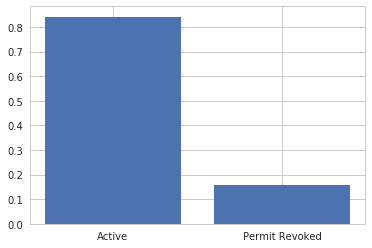

In [101]:
c = data['status'].value_counts()
plt.bar(c.keys(), c / c.sum())
plt.show()

### Total number of allocations per year

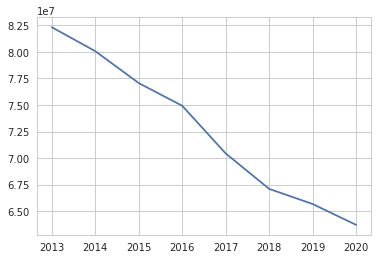

In [102]:
sums = [data[year].sum() for year in YEARS]
plt.plot(YEARS, sums)
plt.show()

### Relative yearly trend

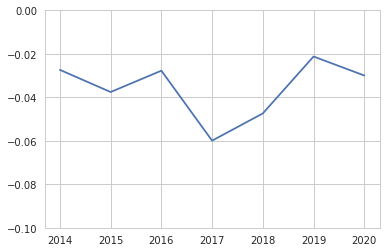

In [103]:
relativeTrends = [(sums[i+1] - sums[i]) / sums[i] for i in range(len(sums)-1)]
plt.plot(YEARS[1:], relativeTrends)
axes = plt.gca()
axes.set_ylim((-0.1, 0))
plt.show()

### Allocations distribution

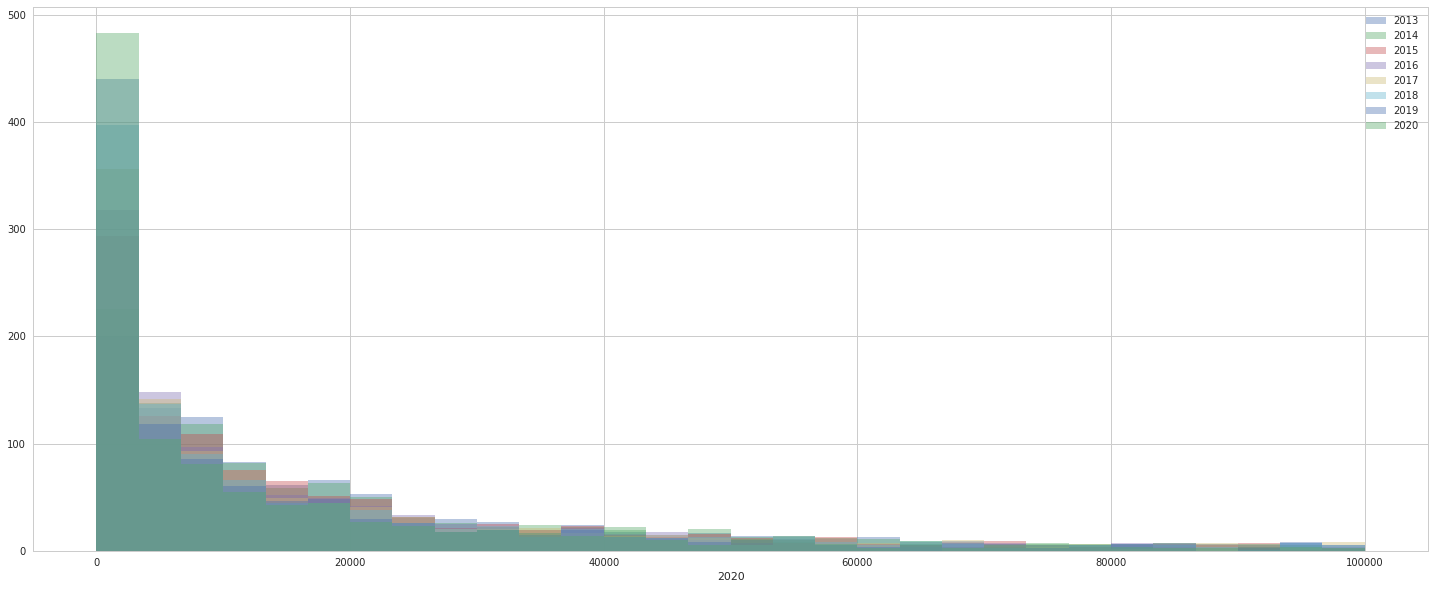

In [104]:
MIN, MAX = 0, 100000
plt.figure(figsize=(25,10))

for year in YEARS:
    sns.distplot(
        data[data[year] < MAX][year],
        bins=30,
        kde=False,
        hist_kws={
            "range": (MIN, MAX)
        },
        label=year
    )
plt.legend()
plt.show()

#### Distribution using stripplot

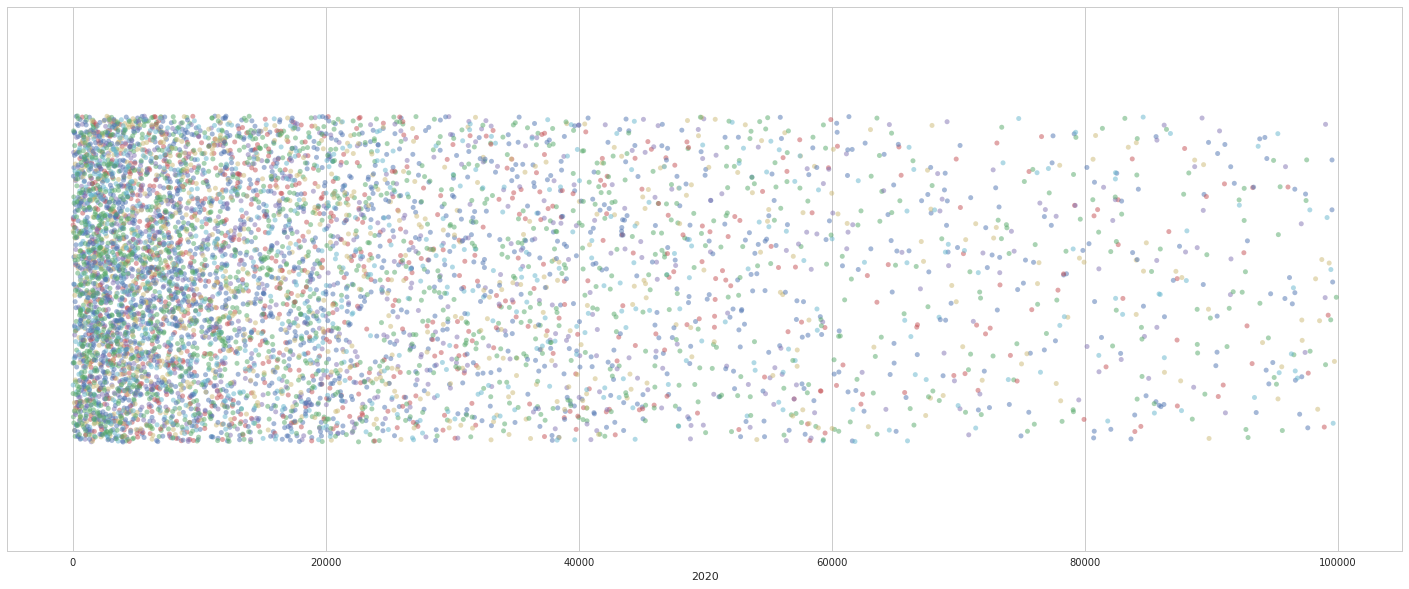

In [117]:
MIN, MAX = 1, 100000
# plt.figure(figsize=(25, 5 * len(YEARS)))
plt.figure(figsize=(25, 10))

ax = plt.gca()

for i, year in enumerate(YEARS):
#     ax = plt.subplot(len(YEARS), 1, i+1)
    color = sns.color_palette(n_colors=len(YEARS))[i]
    sns.stripplot(
        x=year,
        data=data[(data[year] > MIN) & (data[year] < MAX)],
        jitter=0.3,
        ax=ax,
        color=color,
        alpha=0.5
    )
plt.show()

#### Log distribution

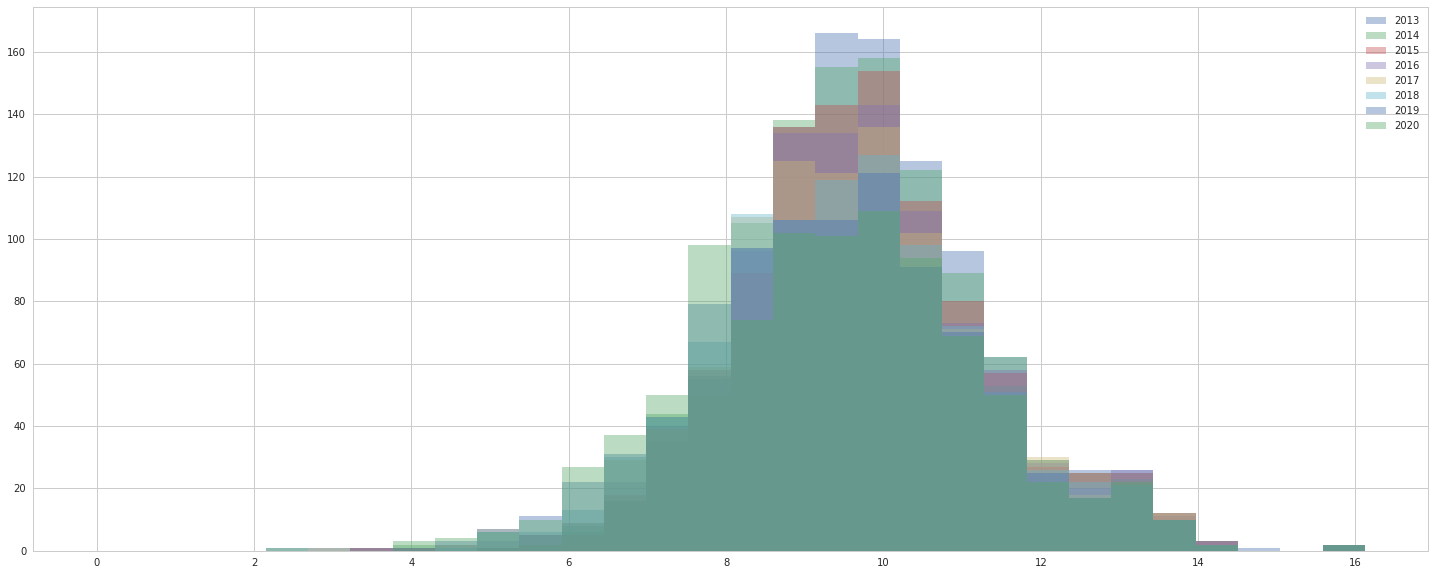

In [112]:
MIN, MAX = 1, 10000000
plt.figure(figsize=(25,10))

for year in YEARS:
    sns.distplot(
        np.log(np.array(data[(data[year] > MIN) & (data[year] < MAX)][year])),
        bins=30,
        kde=False,
        hist_kws={
            "range": (np.log(MIN), np.log(MAX))
        },
        label=year
    )
plt.legend()
plt.show()

### Most carbonated installations' dynamics

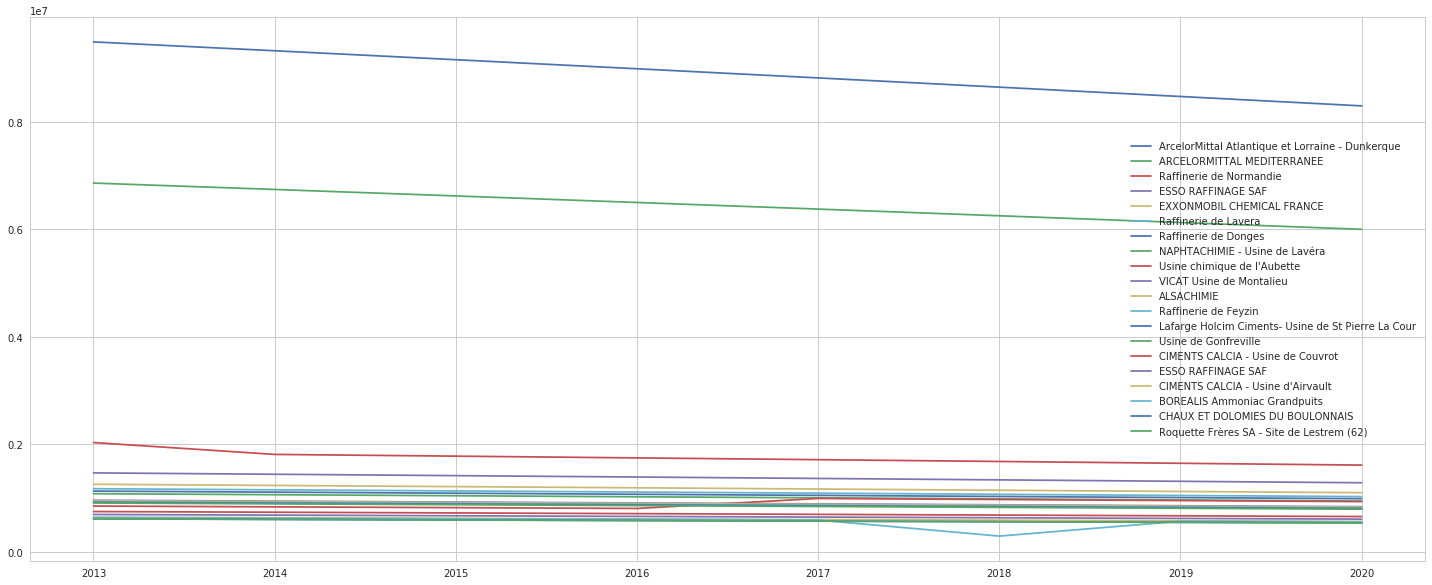

In [145]:
plt.figure(figsize=(25,10))
ds = data.sort_values(by=['2020'], ascending=False)
for installation in ds[:20].iterrows():
    plt.plot(YEARS, installation[1][YEARS], label=installation[1]['installationName'])
plt.legend()
plt.show()

### Annual distribution of relative trends

One computes the evolution of allocations from year `n-1` to year `n`

In [165]:
for year in YEARS[1:]:
    previousYear = str(int(year) - 1)
    data['r' + year] = (data[year] - data[previousYear]) / data[previousYear]

/home/alexis/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/alexis/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


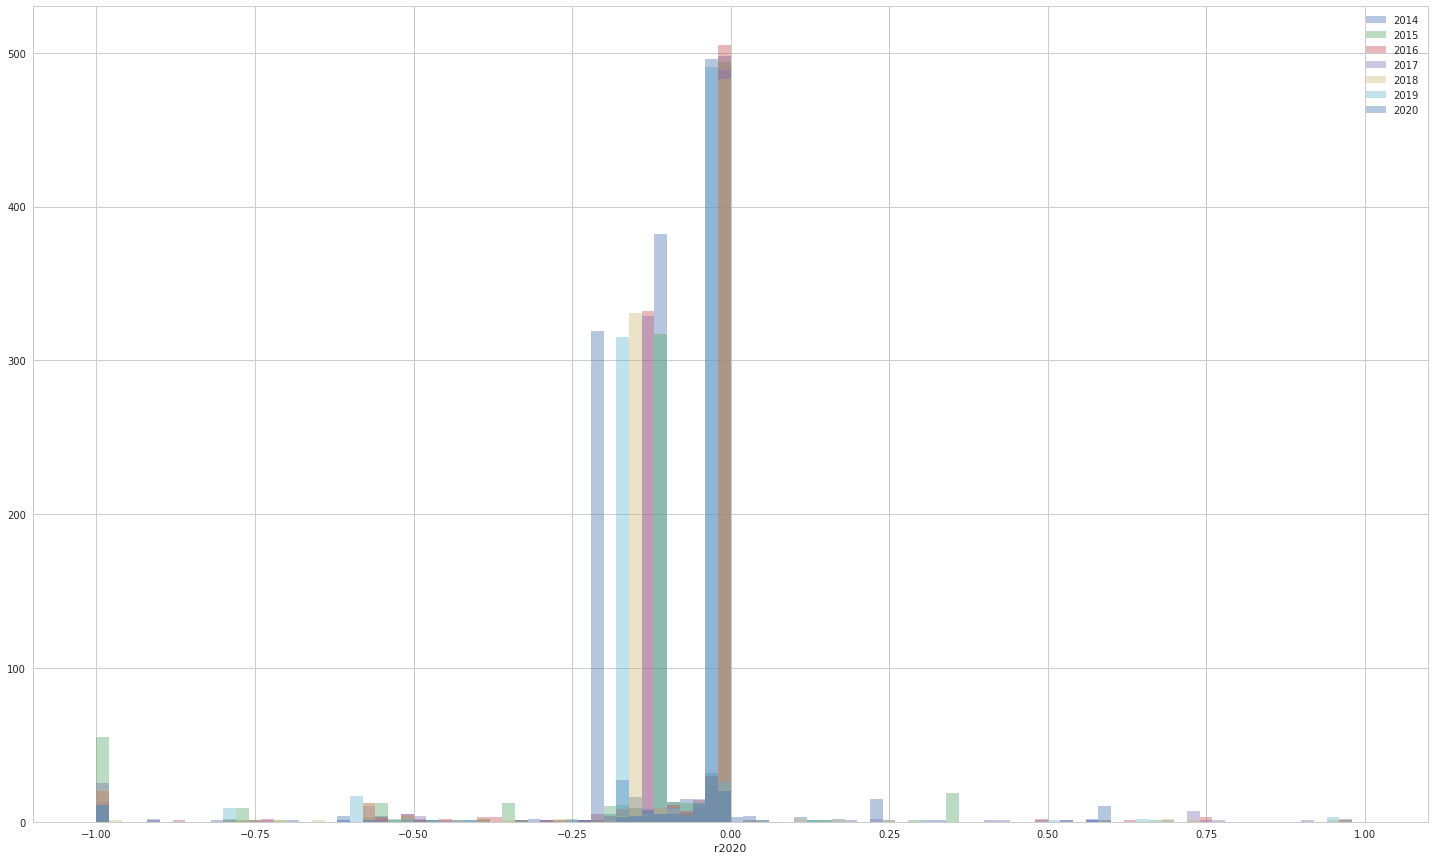

In [170]:
MIN, MAX = -1, 1
plt.figure(figsize=(25,15))

for year in YEARS[1:]:
    sns.distplot(
        data['r' + year],
        label=year,
        bins=100,
        kde=False,
        hist_kws={
            "range": (MIN, MAX)
        }
    )
plt.legend()
plt.show()

#### Closer look at distributions for installations reducing their emissions

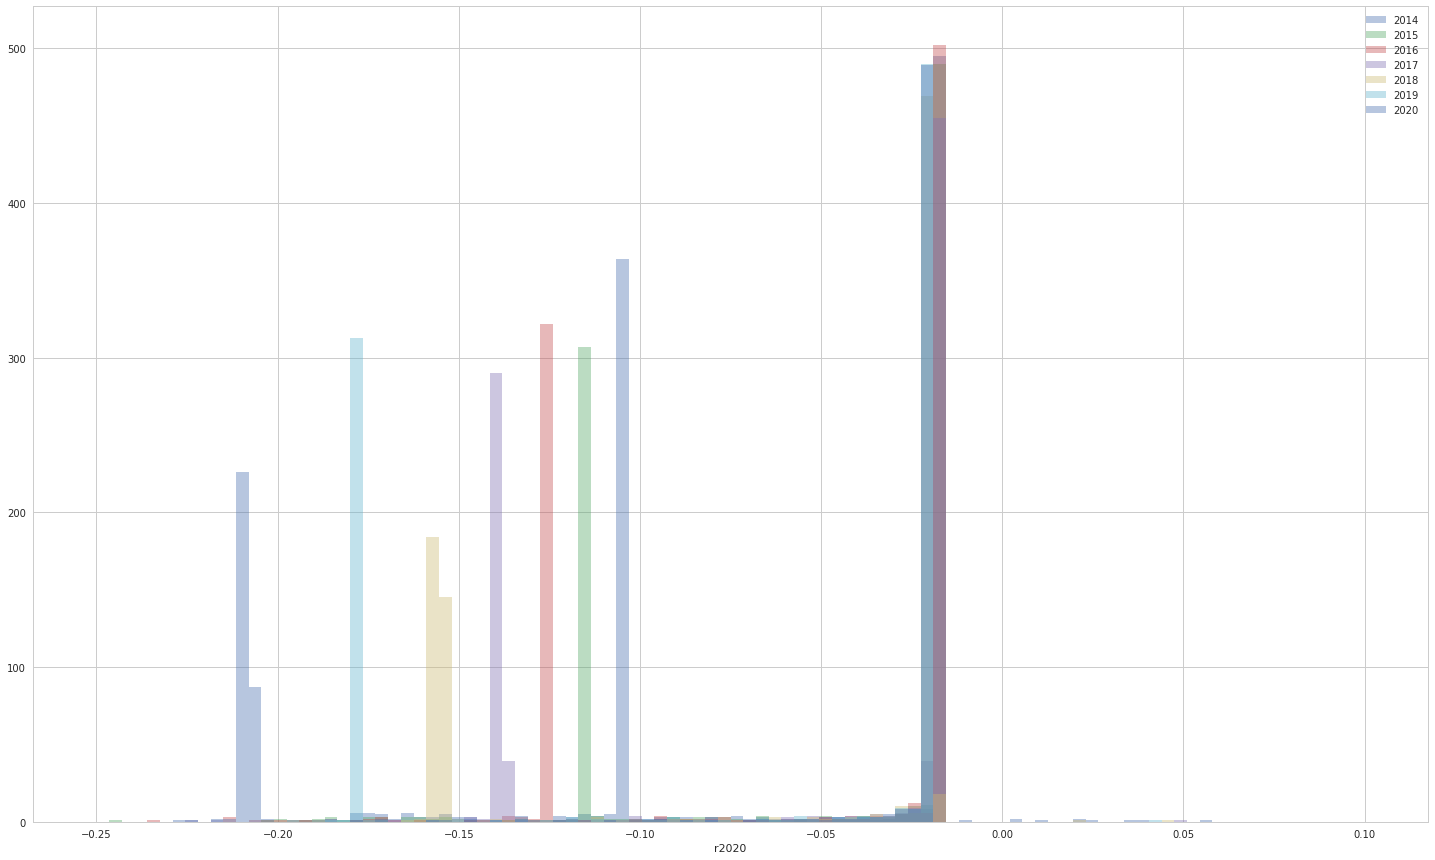

In [171]:
MIN, MAX = -0.25, 0.1
plt.figure(figsize=(25,15))

for year in YEARS[1:]:
    sns.distplot(
        data[data['r' + year] > MIN]['r' + year],
        label=year,
        bins=100,
        kde=False,
        hist_kws={
            "range": (MIN, MAX)
        }
    )
plt.legend()
plt.show()

##### Installations showing high decrease (~20%)

In [189]:
data[(data['r2020'] < -0.20) & (data['r2020'] > -0.24)].sort_values(by=['2020'], ascending=False)[['installationName', '2020', 'r2020']].head(n=10)

,installationName,2020,r2020
559,CPCU - Chaufferie de Saint Ouen I et II,101540,-0.208900
839,Centrale Utilités SOBEGI,76269,-0.208893
433,SNC COGE VITRY,56220,-0.207935
1042,UNILIN SAS,42864,-0.208889
434,CPCU - chaufferie de Saint-Ouen III,42053,-0.207937
729,Station de Bavay (GDF),31681,-0.208905
794,SWISS KRONO SAS,26667,-0.208906
1034,ARMSTRONG BUILDING PRODUCTS SAS,21065,-0.222579
538,CPCU - Chaufferie de Vaugirard,20112,-0.208905
541,ENERTHEM - Centrale Alençon,19090,-0.208901


Proportion of installations common to 2020 and 2019 within these subsets

In [190]:
s2020 = set(data[(data['r2020'] < -0.20) & (data['r2020'] > -0.24)].sort_values(by=['2020'], ascending=False)['installationName'])
s2019 = set(data[(data['r2019'] < -0.15) & (data['r2019'] > -0.20)].sort_values(by=['2019'], ascending=False)['installationName'])
len(s2019.intersection(s2020)) / len(s2019)

0.9498432601880877

#### Even closer look

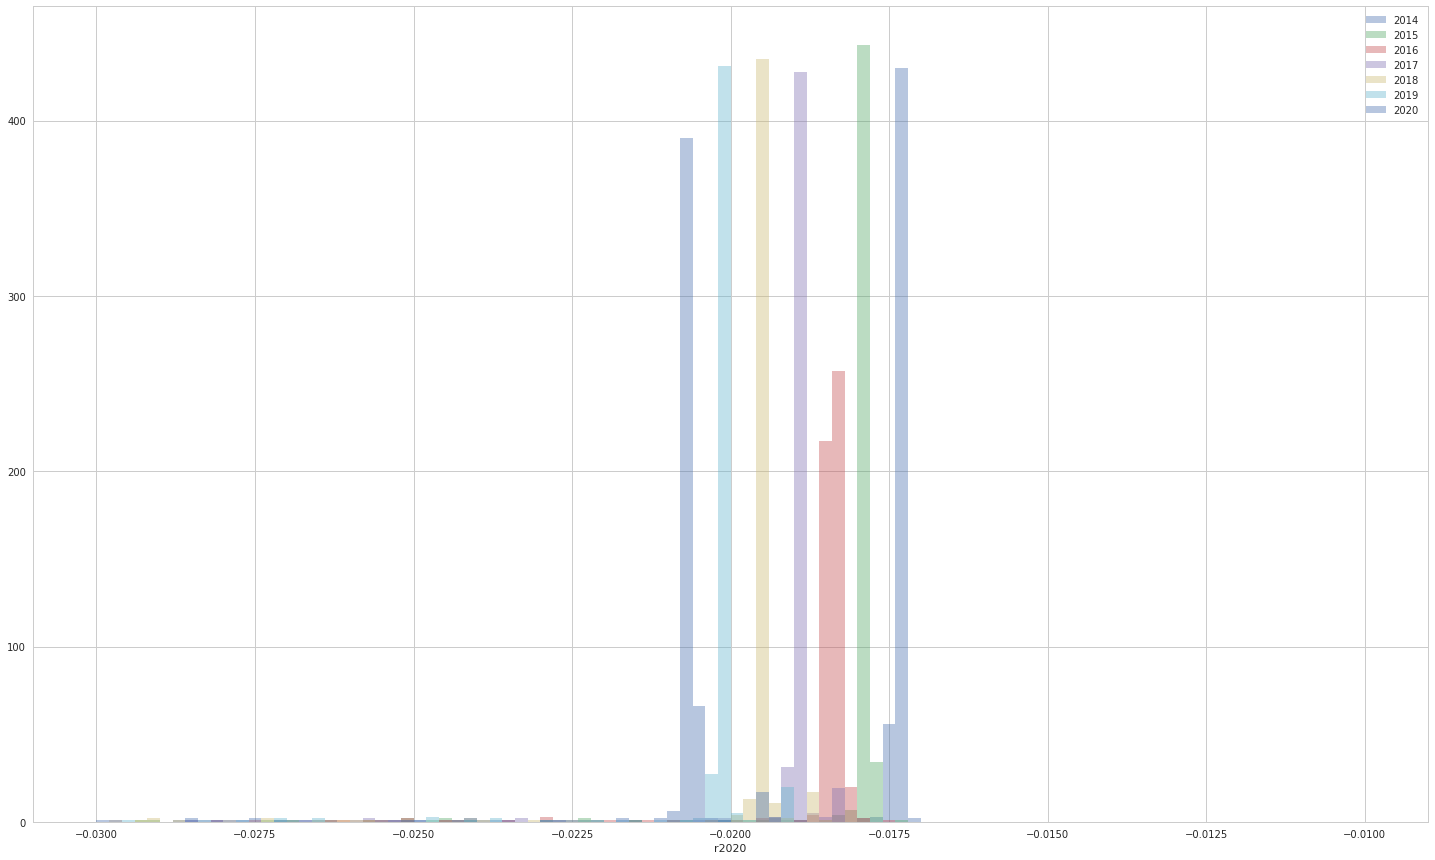

In [175]:
MIN, MAX = -0.03, -0.01
plt.figure(figsize=(25,15))

for year in YEARS[1:]:
    sns.distplot(
        data[(data['r' + year] > MIN) & (data['r' + year] < MAX)]['r' + year],
        label=year,
        bins=100,
        kde=False,
        hist_kws={
            "range": (MIN, MAX)
        }
    )
plt.legend()
plt.show()

##### Installations showing low decrease (~2%)

In [192]:
data[(data['r2020'] < -0.02) & (data['r2020'] > -0.0225)].sort_values(by=['2020'], ascending=False)[['installationName', '2020', 'r2020']].head(n=20)

,installationName,2020,r2020
695,ArcelorMittal Atlantique et Lorraine - Dunkerque,8291093,-0.020621
464,ARCELORMITTAL MEDITERRANEE,5994660,-0.020621
188,Raffinerie de Normandie,1607905,-0.020621
192,ESSO RAFFINAGE SAF,1279341,-0.020620
191,EXXONMOBIL CHEMICAL FRANCE,1094282,-0.020622
452,Raffinerie de Lavera,1021606,-0.020621
412,Raffinerie de Donges,983040,-0.020621
454,NAPHTACHIMIE - Usine de Lavéra,939513,-0.020819
458,Usine chimique de l'Aubette,928640,-0.020621
280,VICAT Usine de Montalieu,834031,-0.020621


Proportion of installations common to 2020 and 2019 within these subsets

In [193]:
s2020 = set(data[(data['r2020'] < -0.02) & (data['r2020'] > -0.0225)].sort_values(by=['2020'], ascending=False)['installationName'])
s2019 = set(data[(data['r2019'] < -0.018) & (data['r2019'] > -0.022)].sort_values(by=['2019'], ascending=False)['installationName'])
len(s2019.intersection(s2020)) / len(s2019)

0.9404517453798767

### 2020's relative trend vs total emissions

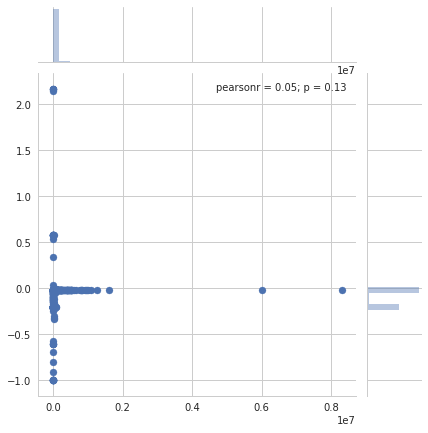

In [221]:
sns.jointplot(
    np.array(data['2020']),
    np.array(data['r2020']),
    kind="scatter"
)

### 2020's relative trend vs _log_ total emissions

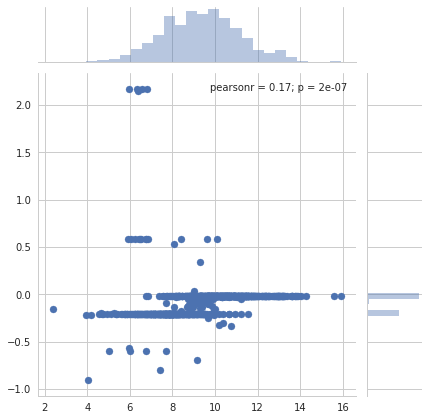

In [222]:
sns.jointplot(
    np.log(np.array(data[data['2020'] > 0]['2020'])),
    np.array(data[data['2020'] > 0]['r2020']),
    kind="scatter"
)

## Compliance data analysis (scraped data)

Data where scraped from 'https://ec.europa.eu/clima/ets/ohaDetails.do?accountID={}&action=all&languageCode=en'
; the main purpose was to get `Allowances in Allocation`, `Verified Emissions` & `Units Surrendered`

In [189]:
# time = '1591874602'
time = '1592221843'

In [190]:
df_installations = pd.read_csv('./data/installations-{}.csv'.format(time), sep=';', quotechar="'")
df_accounts = pd.read_csv('./data/account_holders-{}.csv'.format(time), sep=';', quotechar="'")
df_compliance = pd.read_csv('./data/compliance_history-{}.csv'.format(time), sep=';', quotechar="'")

In [191]:
df_installations.head()

,accountID,installationID,installationName,mainActivity
0,110800,205570,Holcim (Hrvatska) d.o.o.,29-Production of cement clinker
1,105600,4118,Heizwerk Oberhonnefeld,20-Combustion of fuels
2,95200,300,Mont Saint Aignan Energie Verte MAEV,20-Combustion of fuels
3,100401,627,Vuokatin siirrettävä lämpökeskus,99-Other activity opted-in pursuant to Article...
4,110801,205574,SINIAT AUNEUIL,20-Combustion of fuels


In [192]:
df_installations.shape

(17533, 4)

In [193]:
df_accounts.head()

,accountID,installationID,nationalAdministrator,accountType,accountHolderName
0,110800,205570,Croatia,100-Holding Account,Holcim (Hrvatska) d.o.o.
1,105600,4118,Germany,100-Holding Account,I. van Roje & Sohn Sägewerk und Holzhandlung G...
2,95200,300,France,100-Holding Account,Mont-Saint-Aignan Energie Verte- MAEV
3,100401,627,Finland,100-Holding Account,Vapo Oy
4,110801,205574,France,100-Holding Account,SINIAT


In [194]:
df_compliance.head()

,accountID,installationID,year,allowancesInAllocation,verifiedEmissions,unitsSurrendered,complianceCode
0,110800,205570,2005,NaN,NaN,NaN,NaN
1,110800,205570,2006,NaN,NaN,NaN,NaN
2,110800,205570,2007,NaN,NaN,NaN,NaN
3,110800,205570,2008,NaN,NaN,NaN,NaN
4,110800,205570,2009,NaN,NaN,NaN,NaN


### accountID distribution

In [195]:
dfj_installations = df_installations.set_index('accountID').join(df_accounts.set_index('accountID'), rsuffix='account').reset_index()

In [196]:
dfj_installations.head()

,accountID,installationID,installationName,mainActivity,installationIDaccount,nationalAdministrator,accountType,accountHolderName
0,110800,205570,Holcim (Hrvatska) d.o.o.,29-Production of cement clinker,205570,Croatia,100-Holding Account,Holcim (Hrvatska) d.o.o.
1,105600,4118,Heizwerk Oberhonnefeld,20-Combustion of fuels,4118,Germany,100-Holding Account,I. van Roje & Sohn Sägewerk und Holzhandlung G...
2,95200,300,Mont Saint Aignan Energie Verte MAEV,20-Combustion of fuels,300,France,100-Holding Account,Mont-Saint-Aignan Energie Verte- MAEV
3,100401,627,Vuokatin siirrettävä lämpökeskus,99-Other activity opted-in pursuant to Article...,627,Finland,100-Holding Account,Vapo Oy
4,110801,205574,SINIAT AUNEUIL,20-Combustion of fuels,205574,France,100-Holding Account,SINIAT


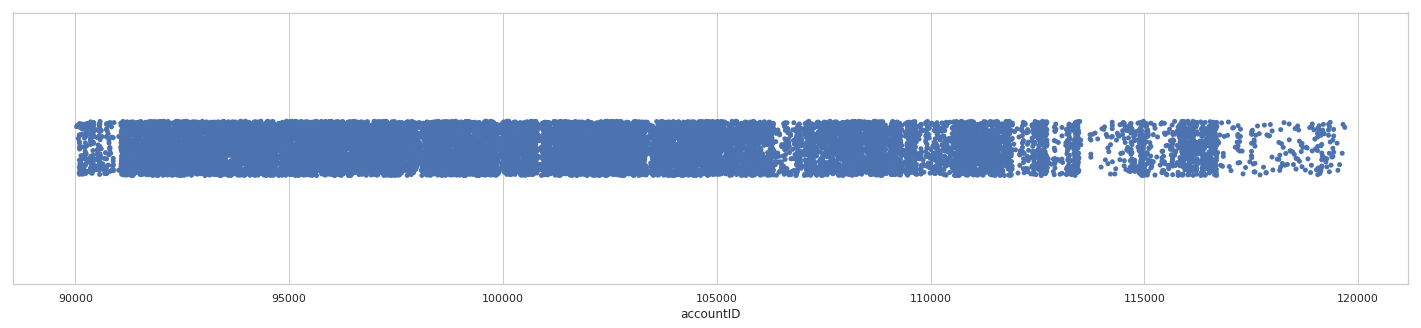

In [197]:
plt.figure(figsize=(25,5))
sns.stripplot(x='accountID', data=dfj_installations)

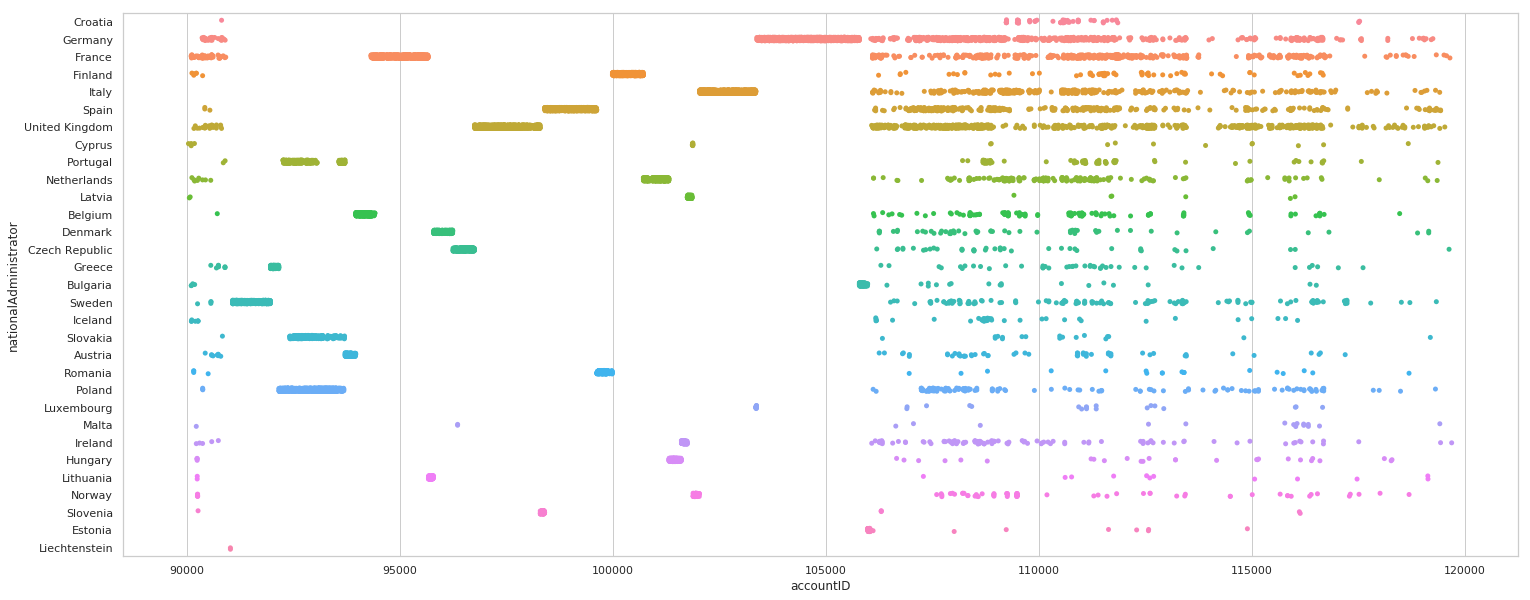

In [198]:
plt.figure(figsize=(25,10))
sns.stripplot(x='accountID', y='nationalAdministrator', data=dfj_installations)

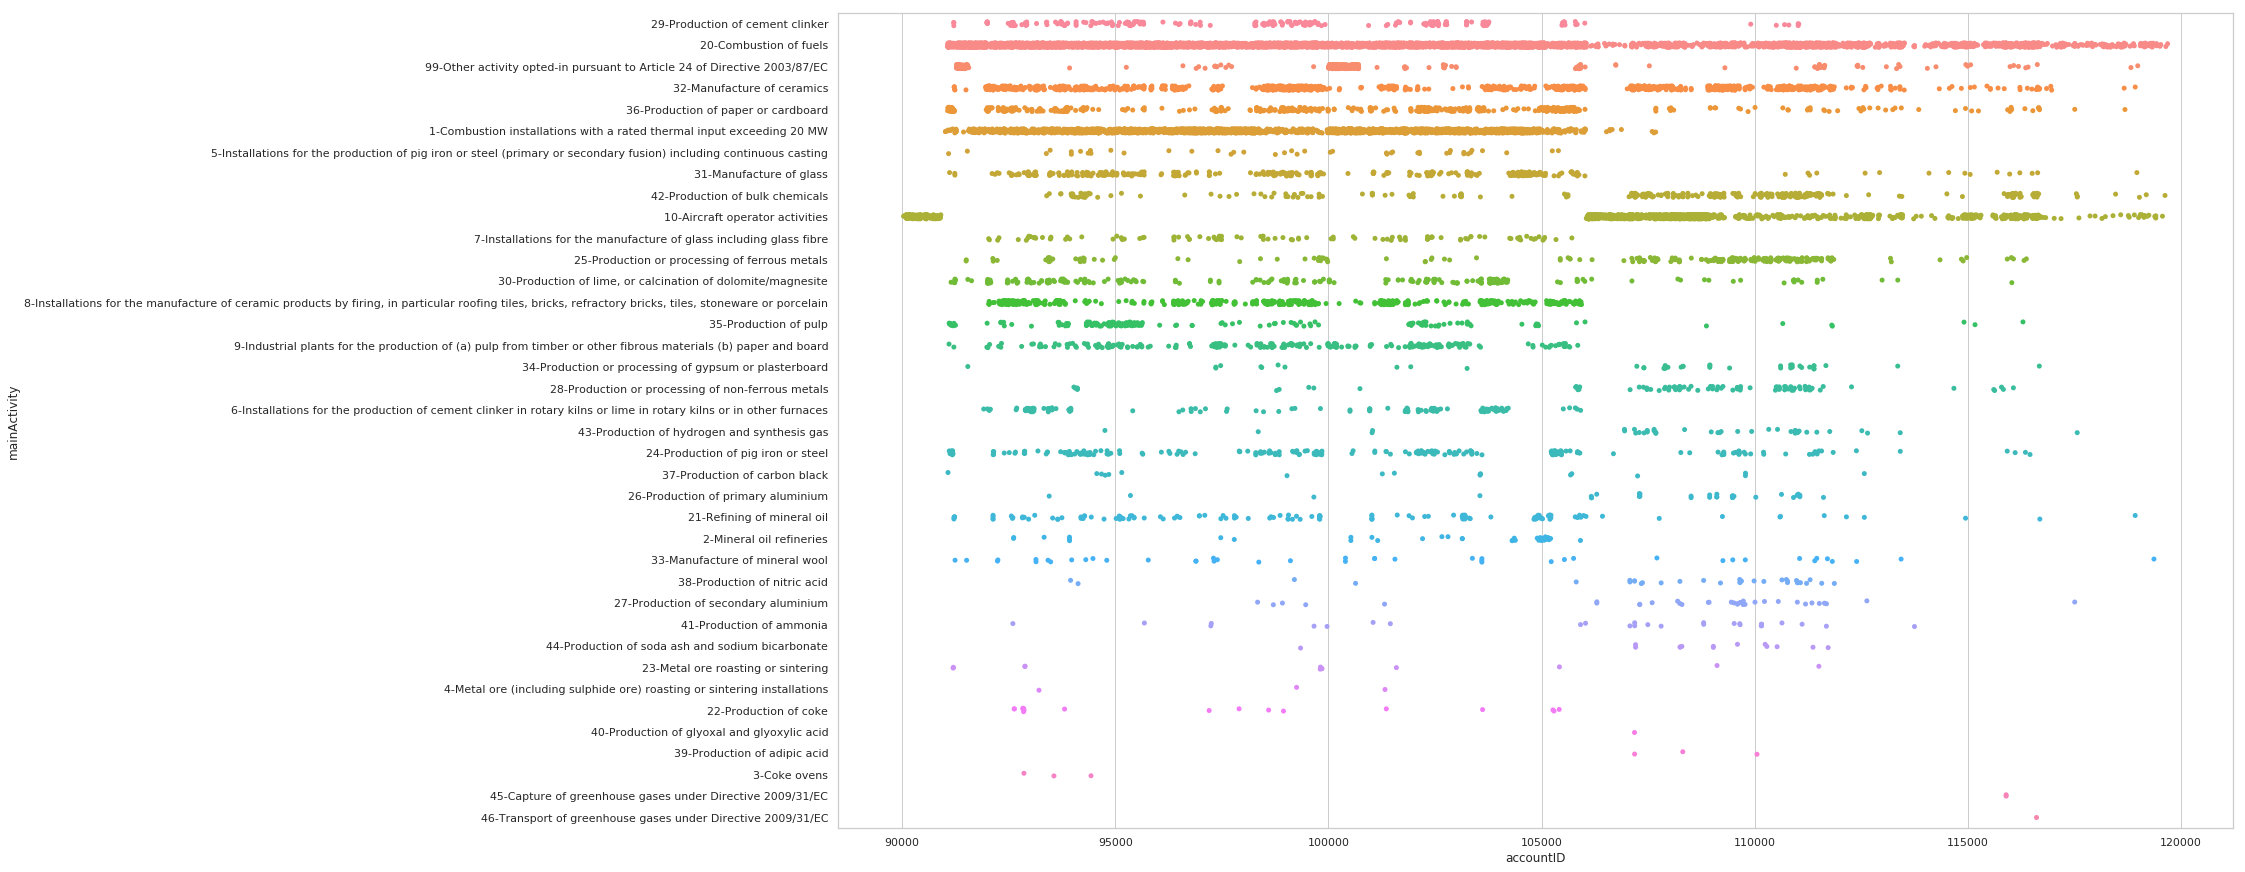

In [199]:
plt.figure(figsize=(25,15))
sns.stripplot(x='accountID', y='mainActivity', data=dfj_installations)

**Accounts could be missing**

### installationID distribution

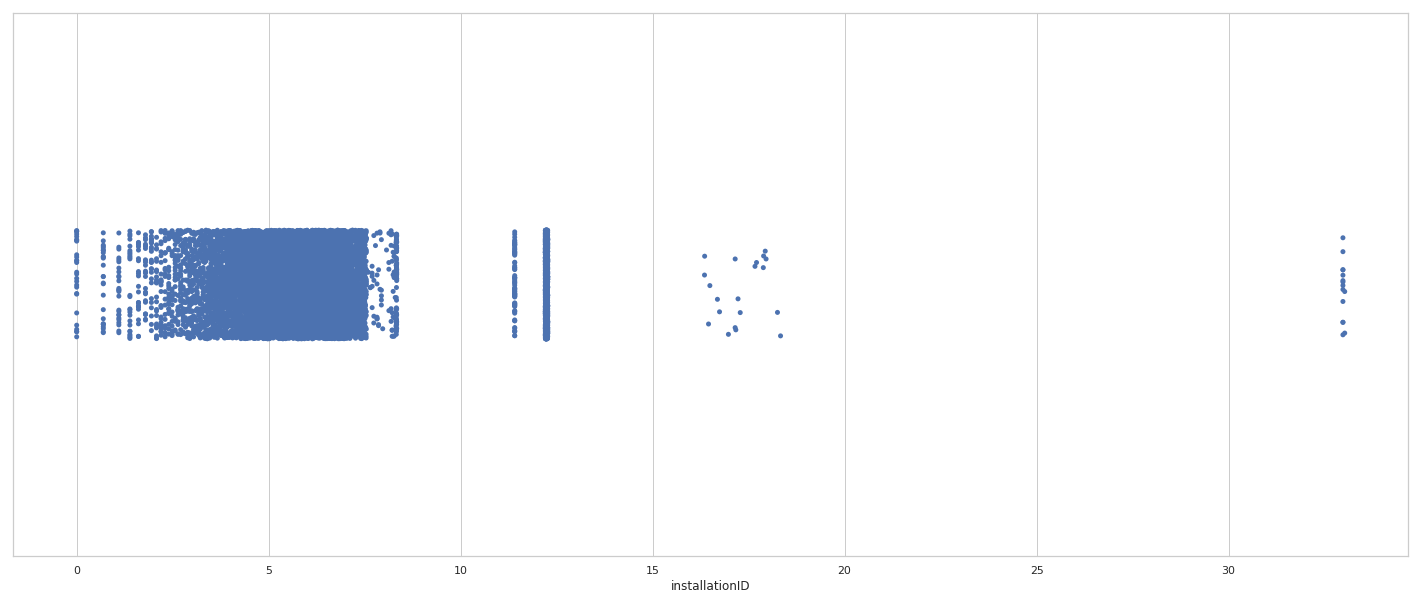

In [200]:
plt.figure(figsize=(25,10))
sns.stripplot(x=np.log(df_installations['installationID']))

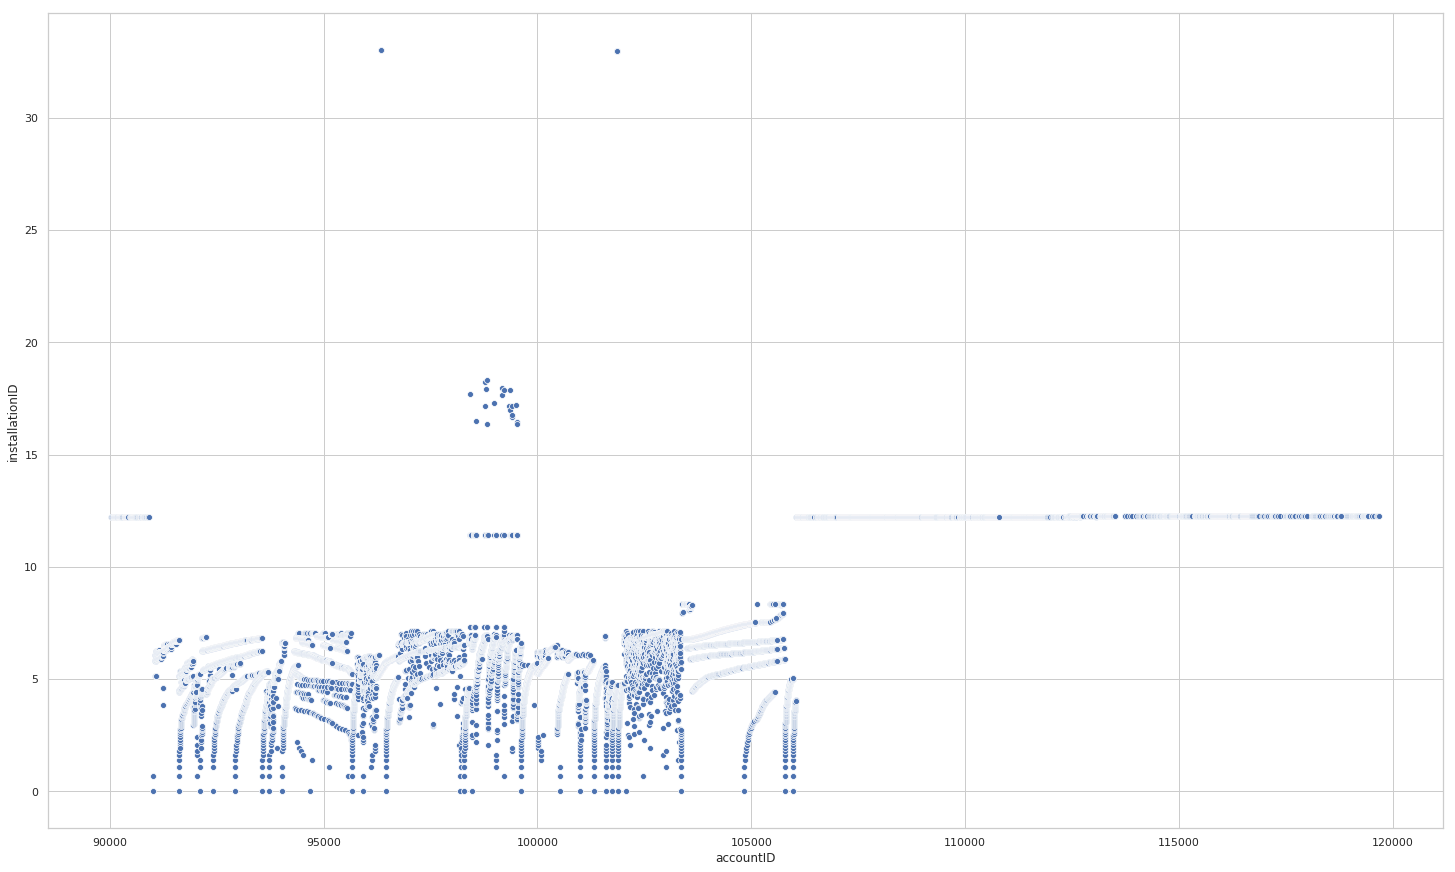

In [201]:
plt.figure(figsize=(25,15))
sns.scatterplot(x=df_installations['accountID'], y=np.log(df_installations['installationID']))

### Compliance distributions

#### Compliance code

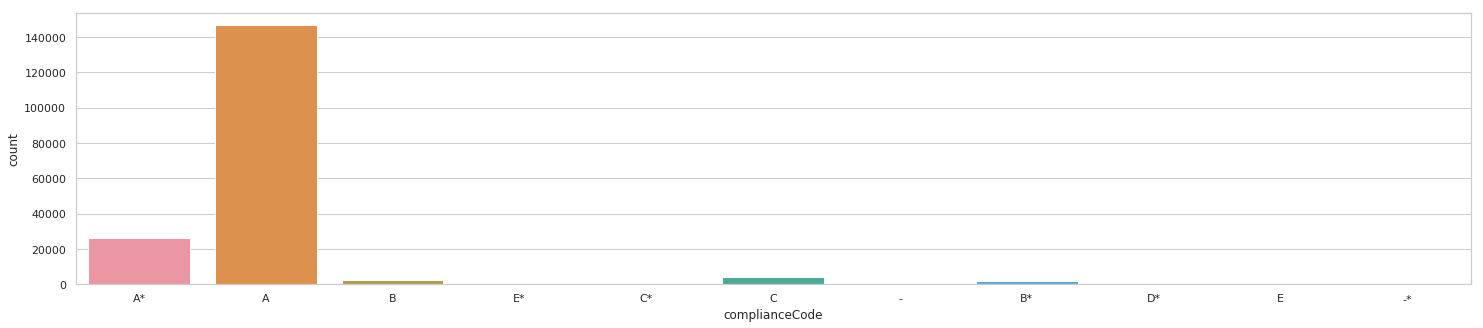

In [202]:
plt.figure(figsize=(25,5))
sns.countplot(x='complianceCode', data=df_compliance)

#### Emissions

In [204]:
df_compliance['verifiedEmissionsProcessed'] = pd.to_numeric(df_compliance['verifiedEmissions'], errors='coerce')
df_compliance['unitsSurrenderedProcessed'] = pd.to_numeric(df_compliance['unitsSurrendered'], errors='coerce')

In [205]:
df_compliance['veal'] = df_compliance['verifiedEmissionsProcessed'] / df_compliance['allowancesInAllocation']
df_compliance['suve'] = df_compliance['unitsSurrenderedProcessed'] / df_compliance['verifiedEmissionsProcessed']
df_compliance['sual'] = df_compliance['unitsSurrenderedProcessed'] / df_compliance['allowancesInAllocation']
df_compliance.replace([np.inf, -np.inf], np.nan, inplace=True)

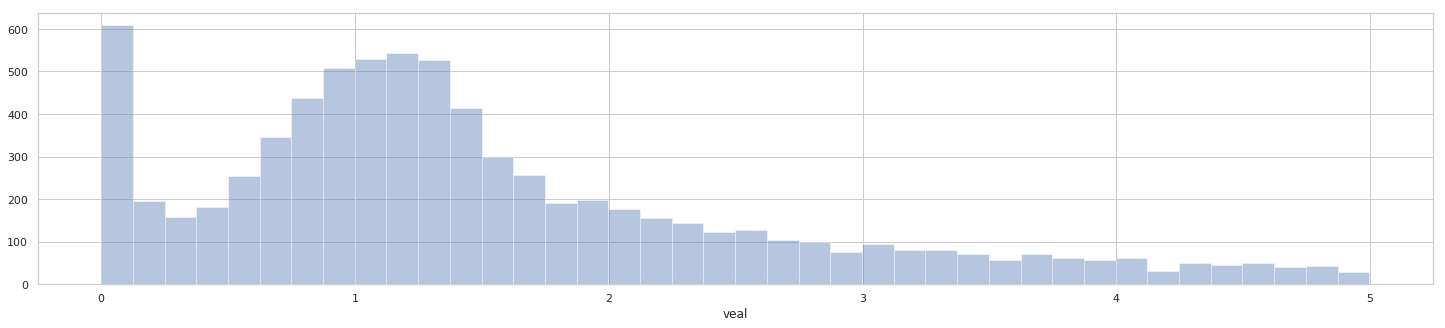

In [206]:
plt.figure(figsize=(25,5))
sns.distplot(df_compliance[(df_compliance['veal'] < 5) & (df_compliance['year'] == 2019)]['veal'], kde=False)

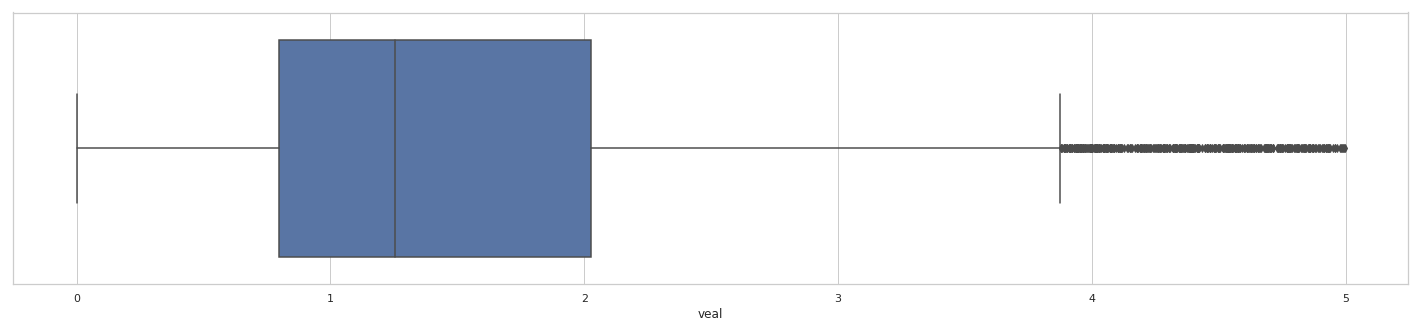

In [207]:
plt.figure(figsize=(25,5))
sns.boxplot(df_compliance[(df_compliance['veal'] < 5) & (df_compliance['year'] == 2019)]['veal'])

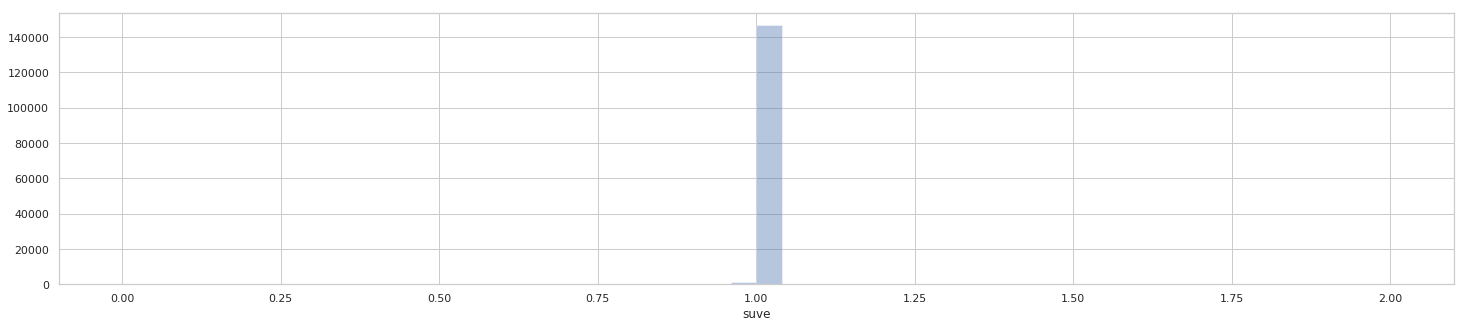

In [208]:
plt.figure(figsize=(25,5))
sns.distplot(df_compliance[df_compliance['suve'] < 2]['suve'], kde=False)

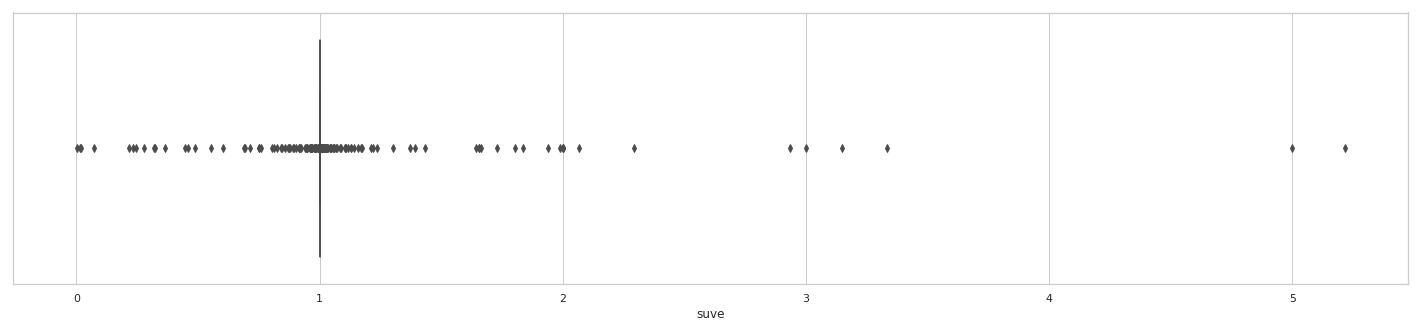

In [209]:
plt.figure(figsize=(25,5))
sns.boxplot(df_compliance[(df_compliance['veal'] < 5) & (df_compliance['year'] == 2019)]['suve'])

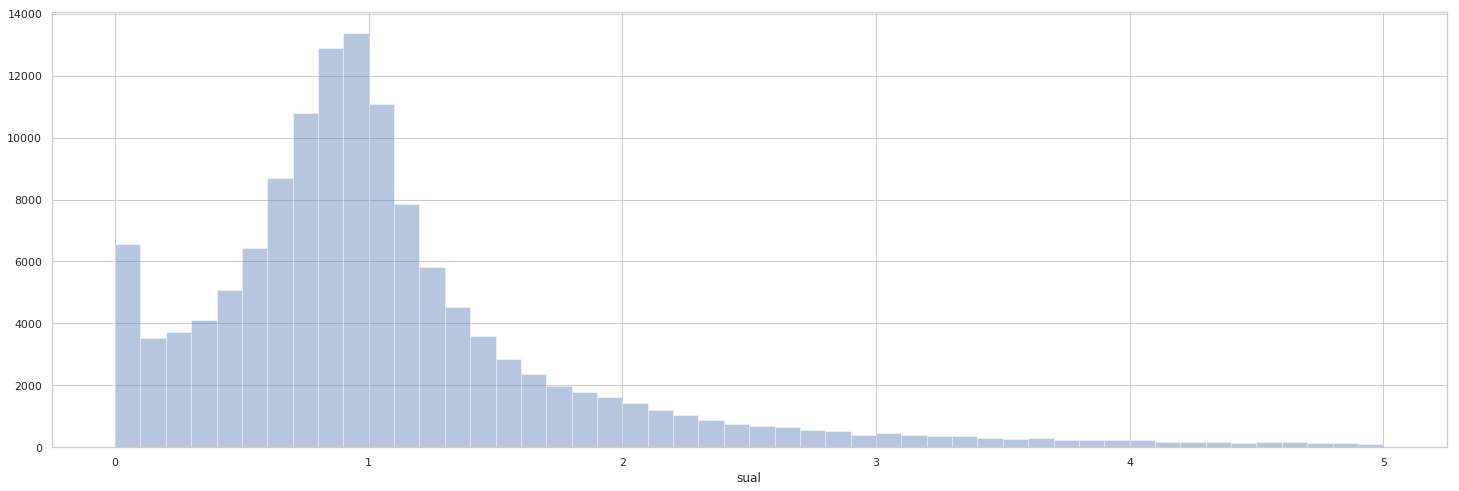

In [210]:
plt.figure(figsize=(25,8))
sns.distplot(df_compliance[df_compliance['sual'] < 5]['sual'], kde=False)

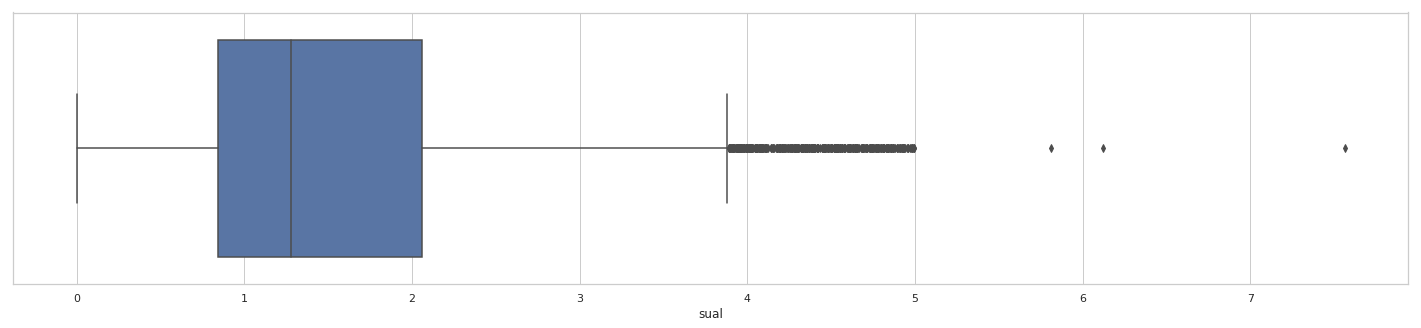

In [211]:
plt.figure(figsize=(25,5))
sns.boxplot(df_compliance[(df_compliance['veal'] < 5) & (df_compliance['year'] == 2019)]['sual'])

### Categories

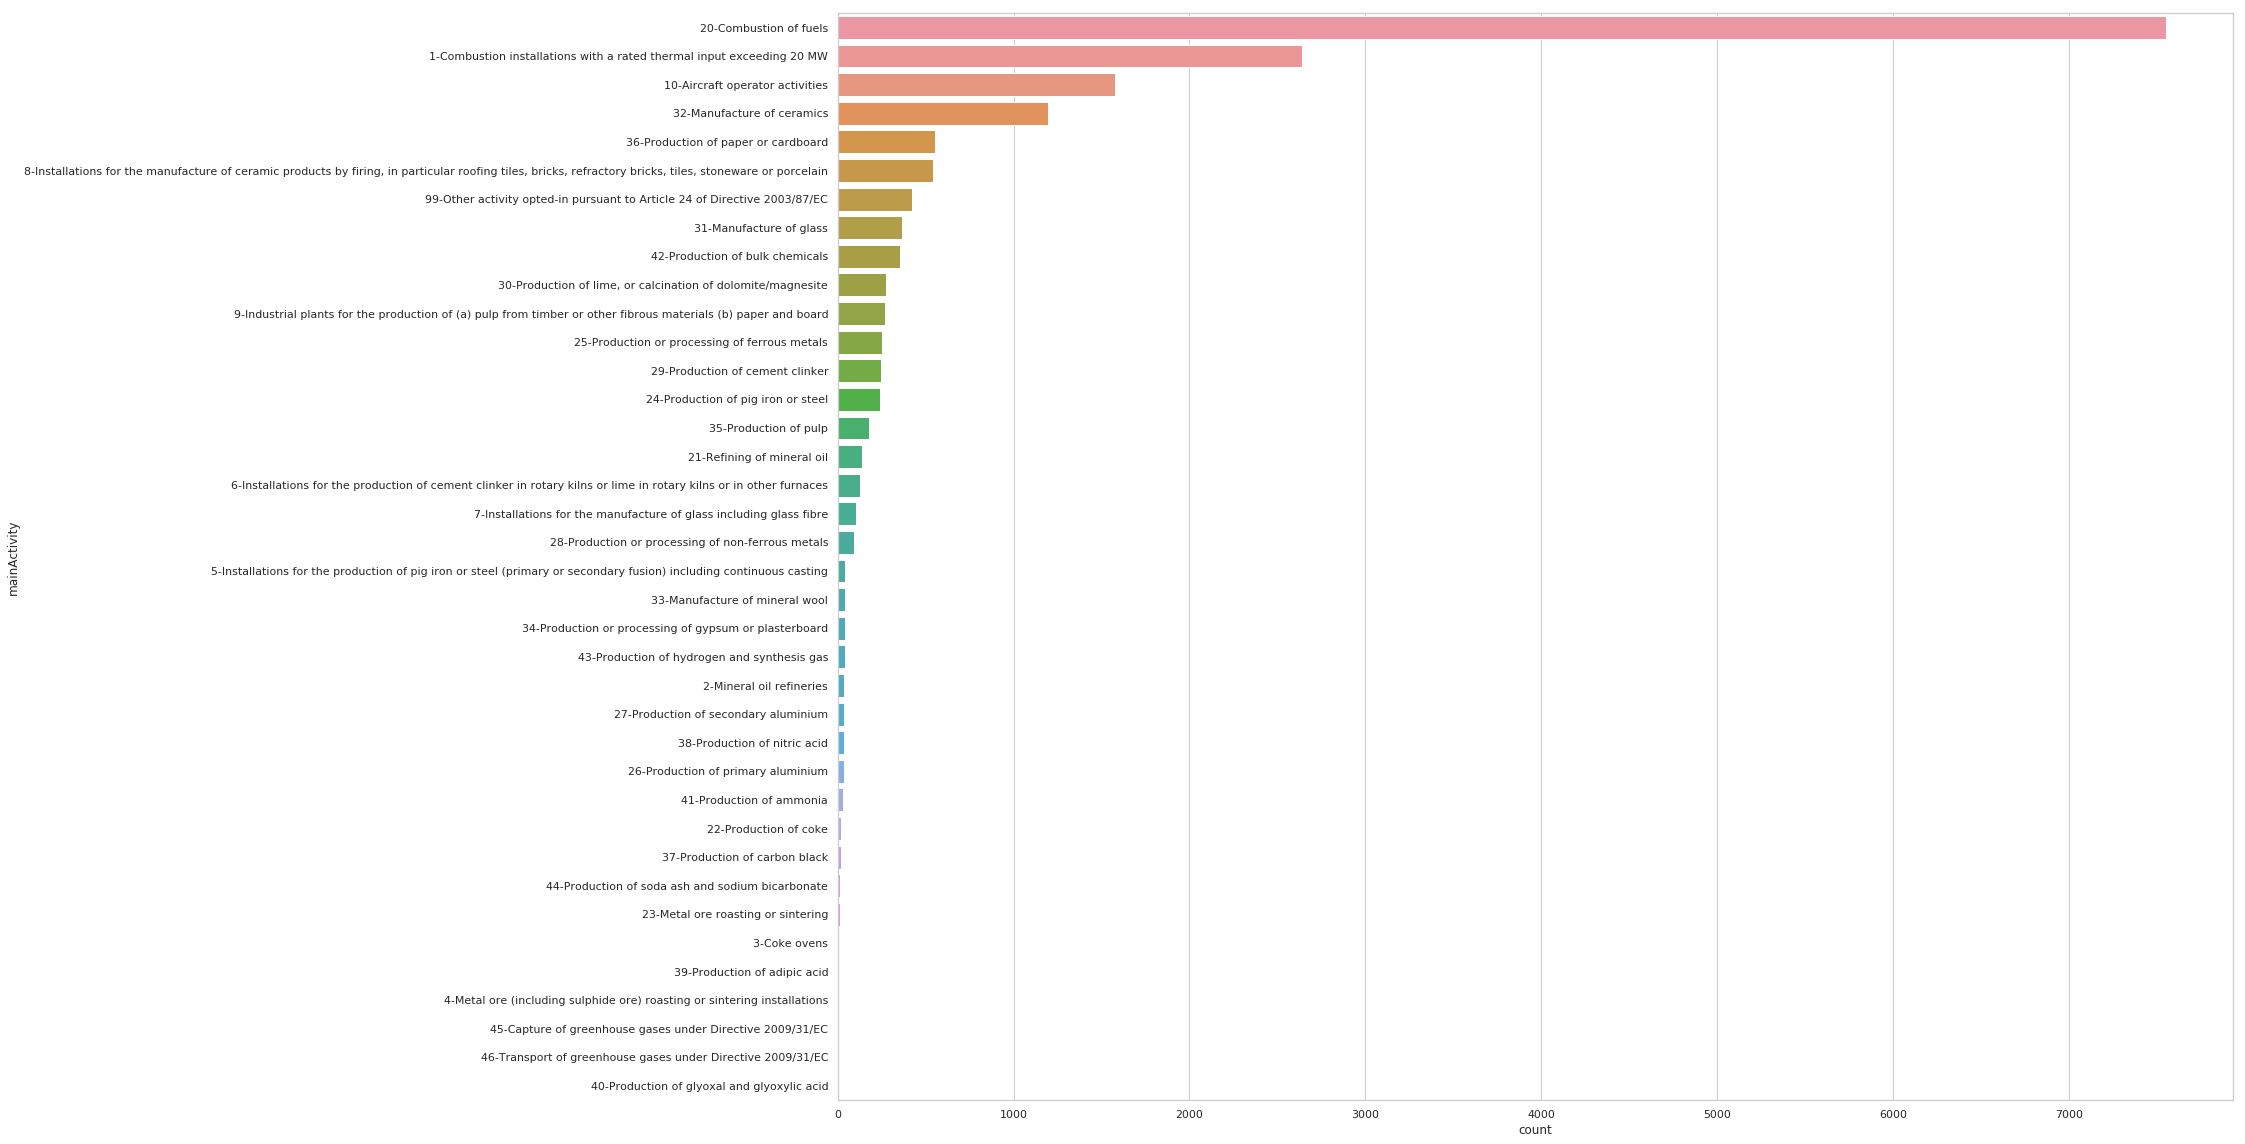

In [212]:
plt.figure(figsize=(25,20))
sns.countplot(
    y='mainActivity',
    data=df_installations,
    order=df_installations.groupby('mainActivity')['installationID'].count().sort_values(ascending=False).index
)

#### Allowances per category

In [213]:
dfj_compliance = df_compliance.set_index('accountID').join(df_installations.set_index('accountID'), rsuffix='installation').reset_index()

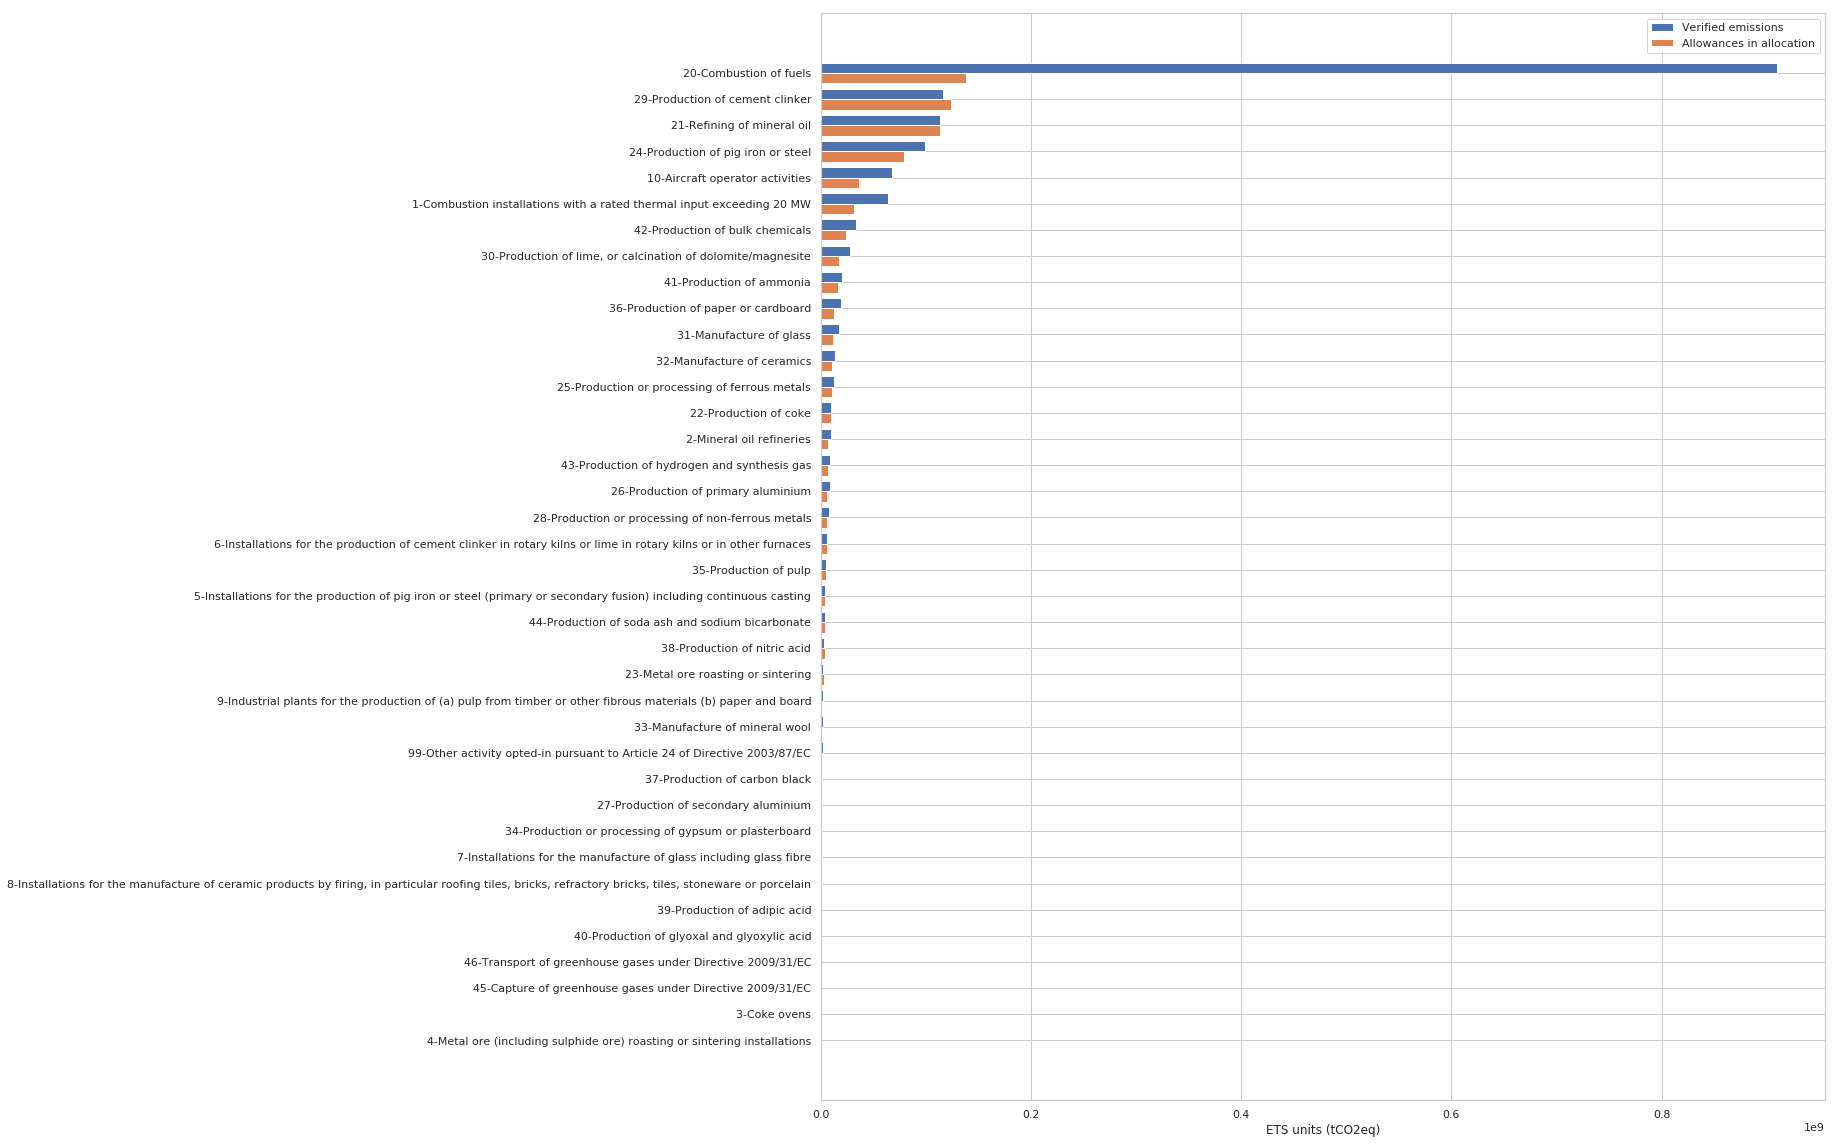

In [264]:
plt.figure(figsize=(18,20))

dfs = dfj_compliance[dfj_compliance['year'] == 2019].groupby('mainActivity')['verifiedEmissionsProcessed'].sum().sort_values()
dfs2 = dfj_compliance[dfj_compliance['year'] == 2019].groupby('mainActivity')['allowancesInAllocation'].sum().sort_values()

x = np.arange(len(dfs.index))  # the label locations
width = 0.4  # the width of the bars

ax = plt.gca()
ax.barh(x + width / 2, dfs, width, label='Verified emissions')
ax.barh(x - width / 2, dfs2, width, label='Allowances in allocation')
ax.set_yticks(x)
ax.set_yticklabels(dfs.index)
ax.set_xlabel('ETS units (tCO2eq)')
plt.legend()
plt.show()

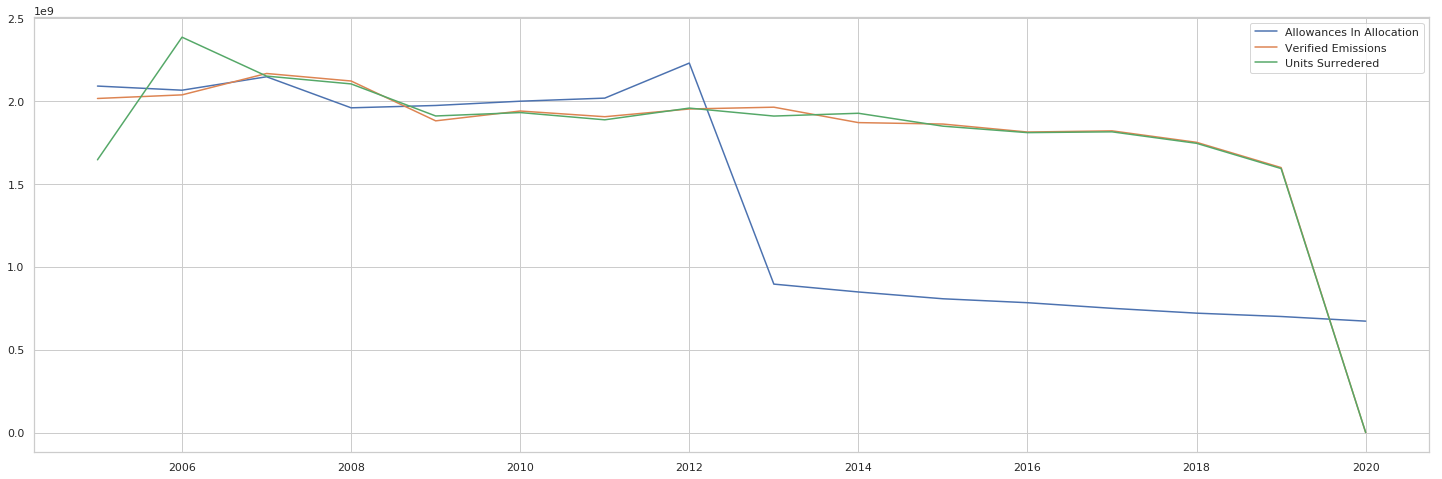

In [215]:
plt.figure(figsize=(25,8))
dfs = df_compliance.groupby('year').sum().reset_index()
plt.plot('year', 'allowancesInAllocation', data=dfs, label='Allowances In Allocation')
plt.plot('year', 'verifiedEmissionsProcessed', data=dfs, label='Verified Emissions')
plt.plot('year', 'unitsSurrenderedProcessed', data=dfs, label='Units Surredered')
plt.legend()

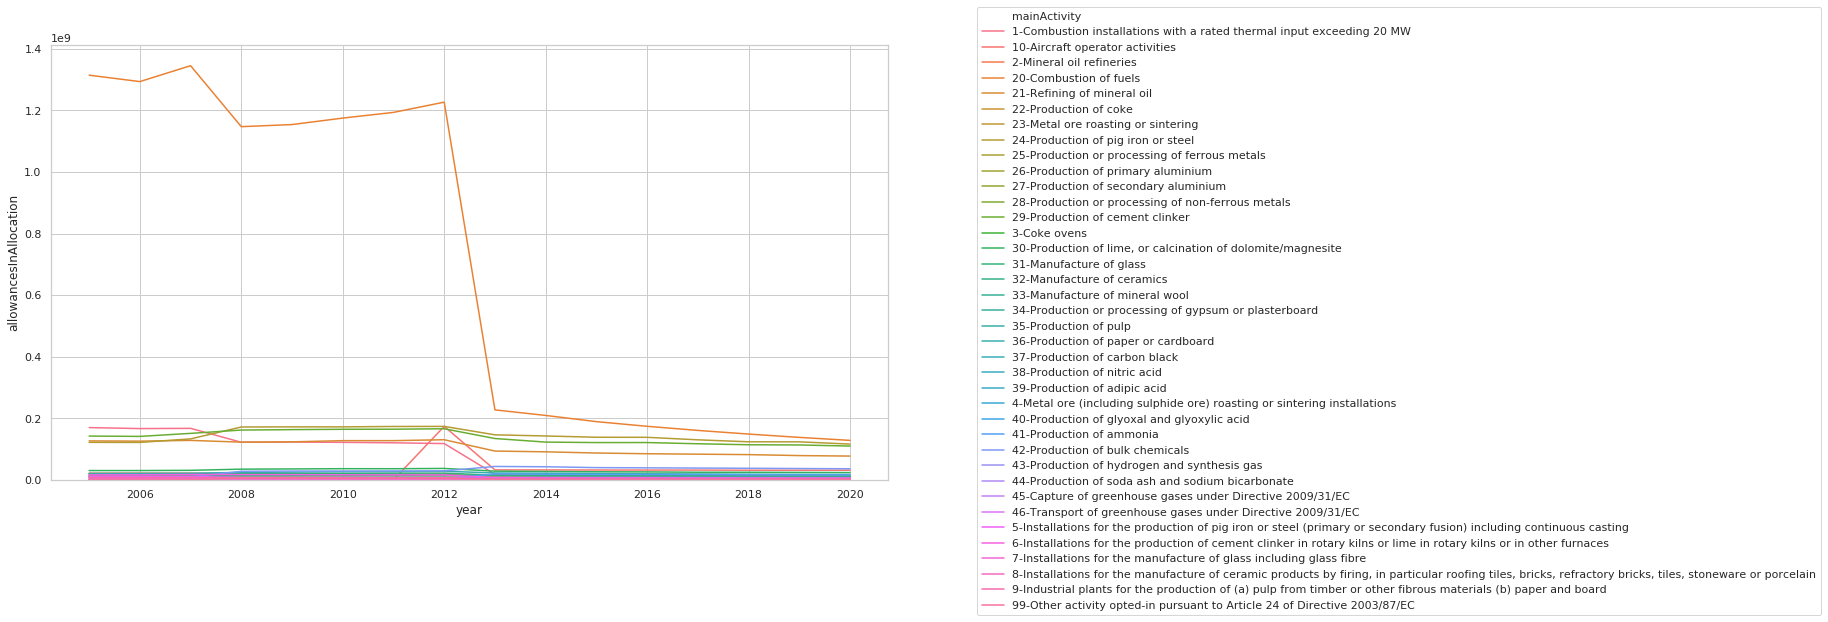

In [216]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(
    x='year',
    y='allowancesInAllocation',
    hue='mainActivity',
    data=dfj_compliance.groupby(['year','mainActivity']).sum().reset_index()
)

ax.set_ylim([0,None])
plt.legend(bbox_to_anchor=(1.1, 1.1), bbox_transform=ax.transAxes)

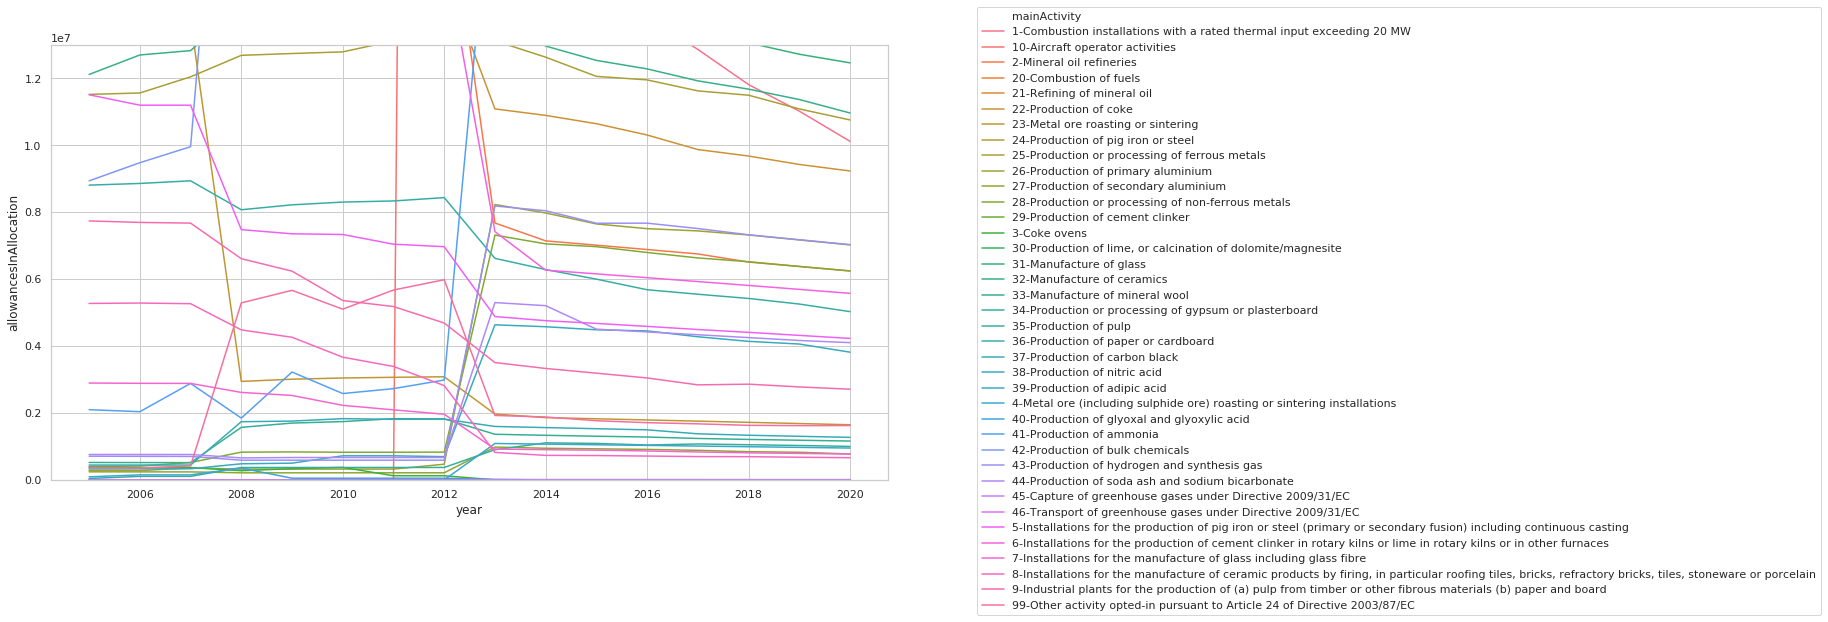

In [217]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(
    x='year',
    y='allowancesInAllocation',
    hue='mainActivity',
    data=dfj_compliance.groupby(['year','mainActivity']).sum().reset_index()
)

ax.set_ylim([0,0.13*10**8])
plt.legend(bbox_to_anchor=(1.1, 1.1), bbox_transform=ax.transAxes)

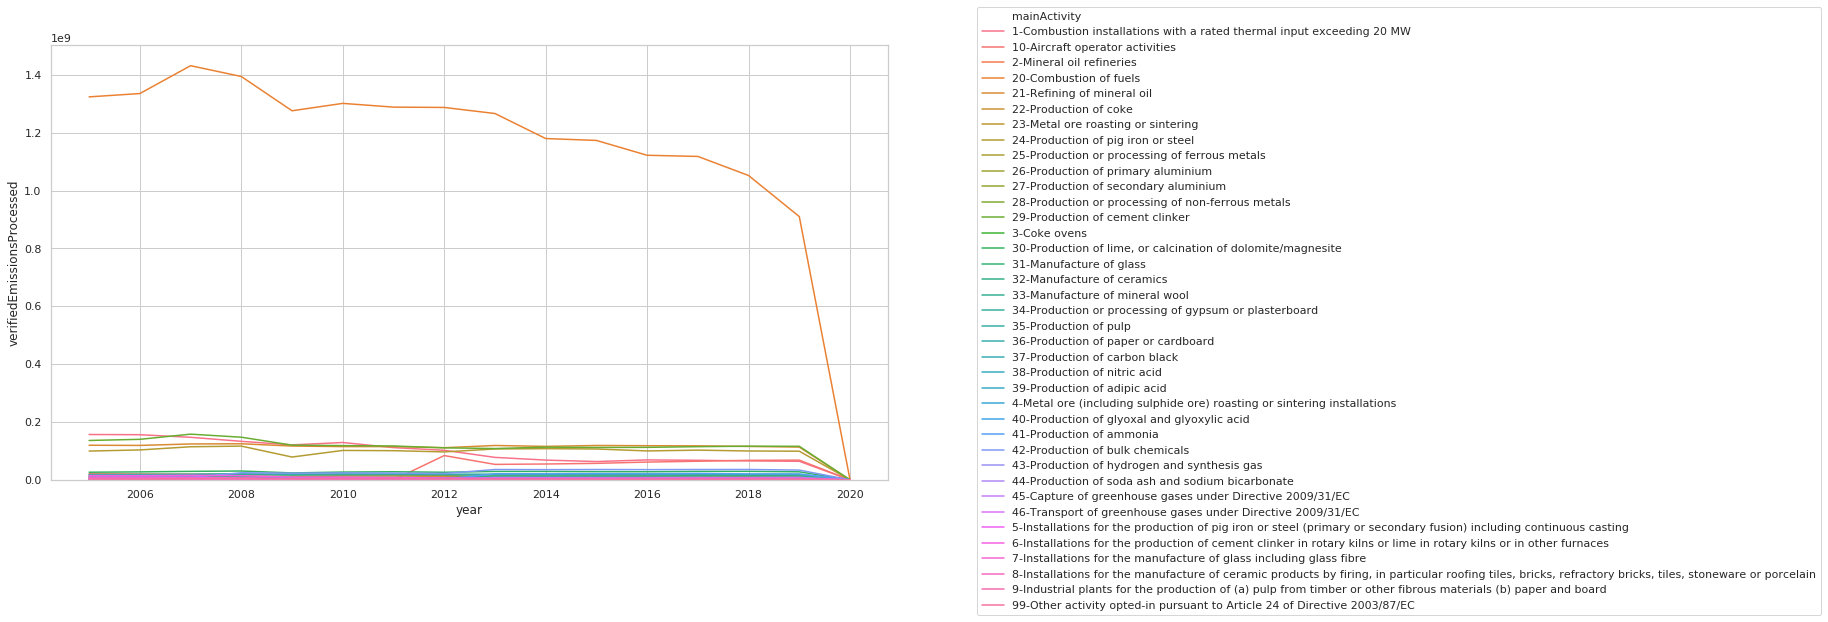

In [218]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(
    x='year',
    y='verifiedEmissionsProcessed',
    hue='mainActivity',
    data=dfj_compliance.groupby(['year','mainActivity']).sum().reset_index()
)

ax.set_ylim([0,None])
plt.legend(bbox_to_anchor=(1.1, 1.1), bbox_transform=ax.transAxes)

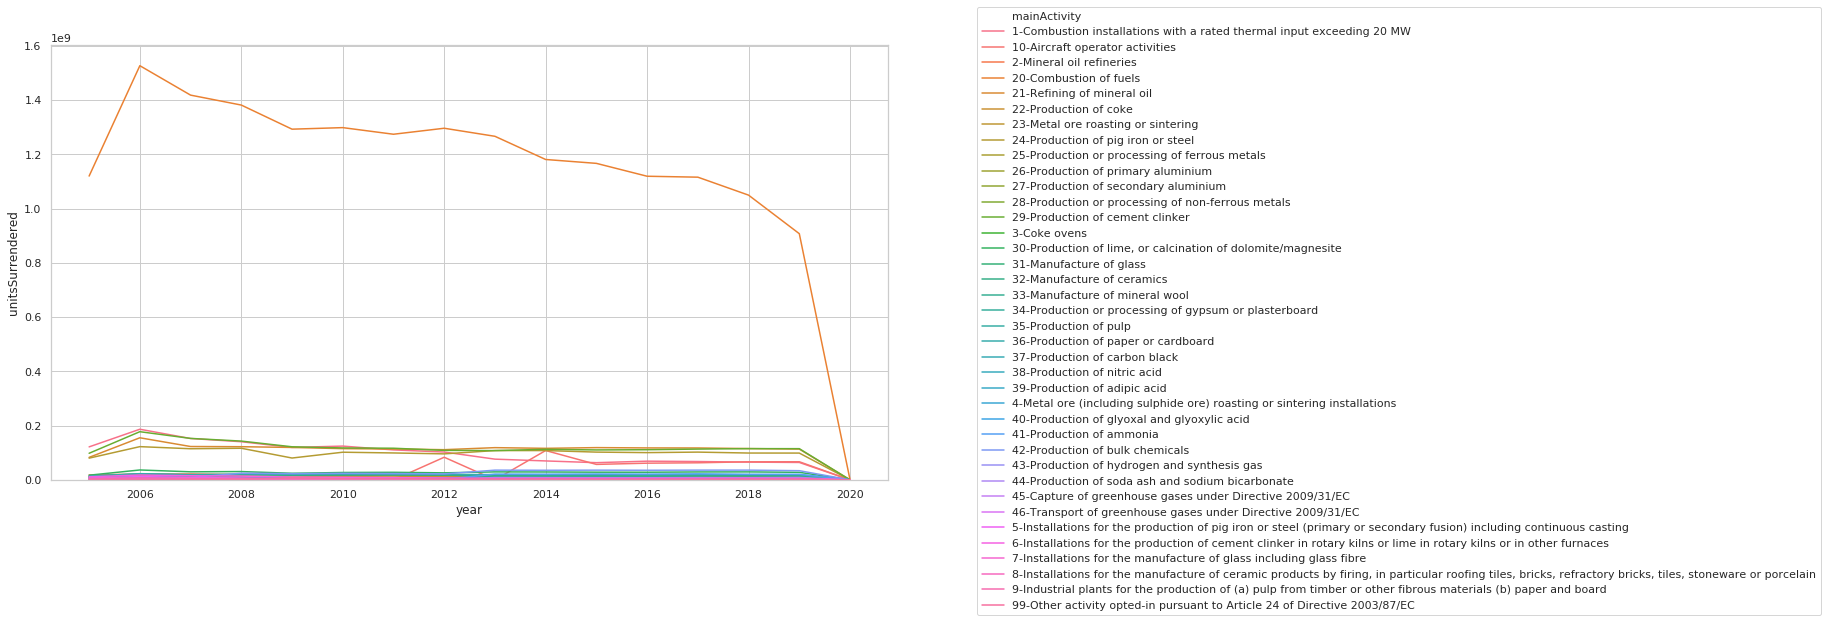

In [219]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(
    x='year',
    y='unitsSurrendered',
    hue='mainActivity',
    data=dfj_compliance.groupby(['year','mainActivity']).sum().reset_index()
)

ax.set_ylim([0,None])
plt.legend(bbox_to_anchor=(1.1, 1.1), bbox_transform=ax.transAxes)

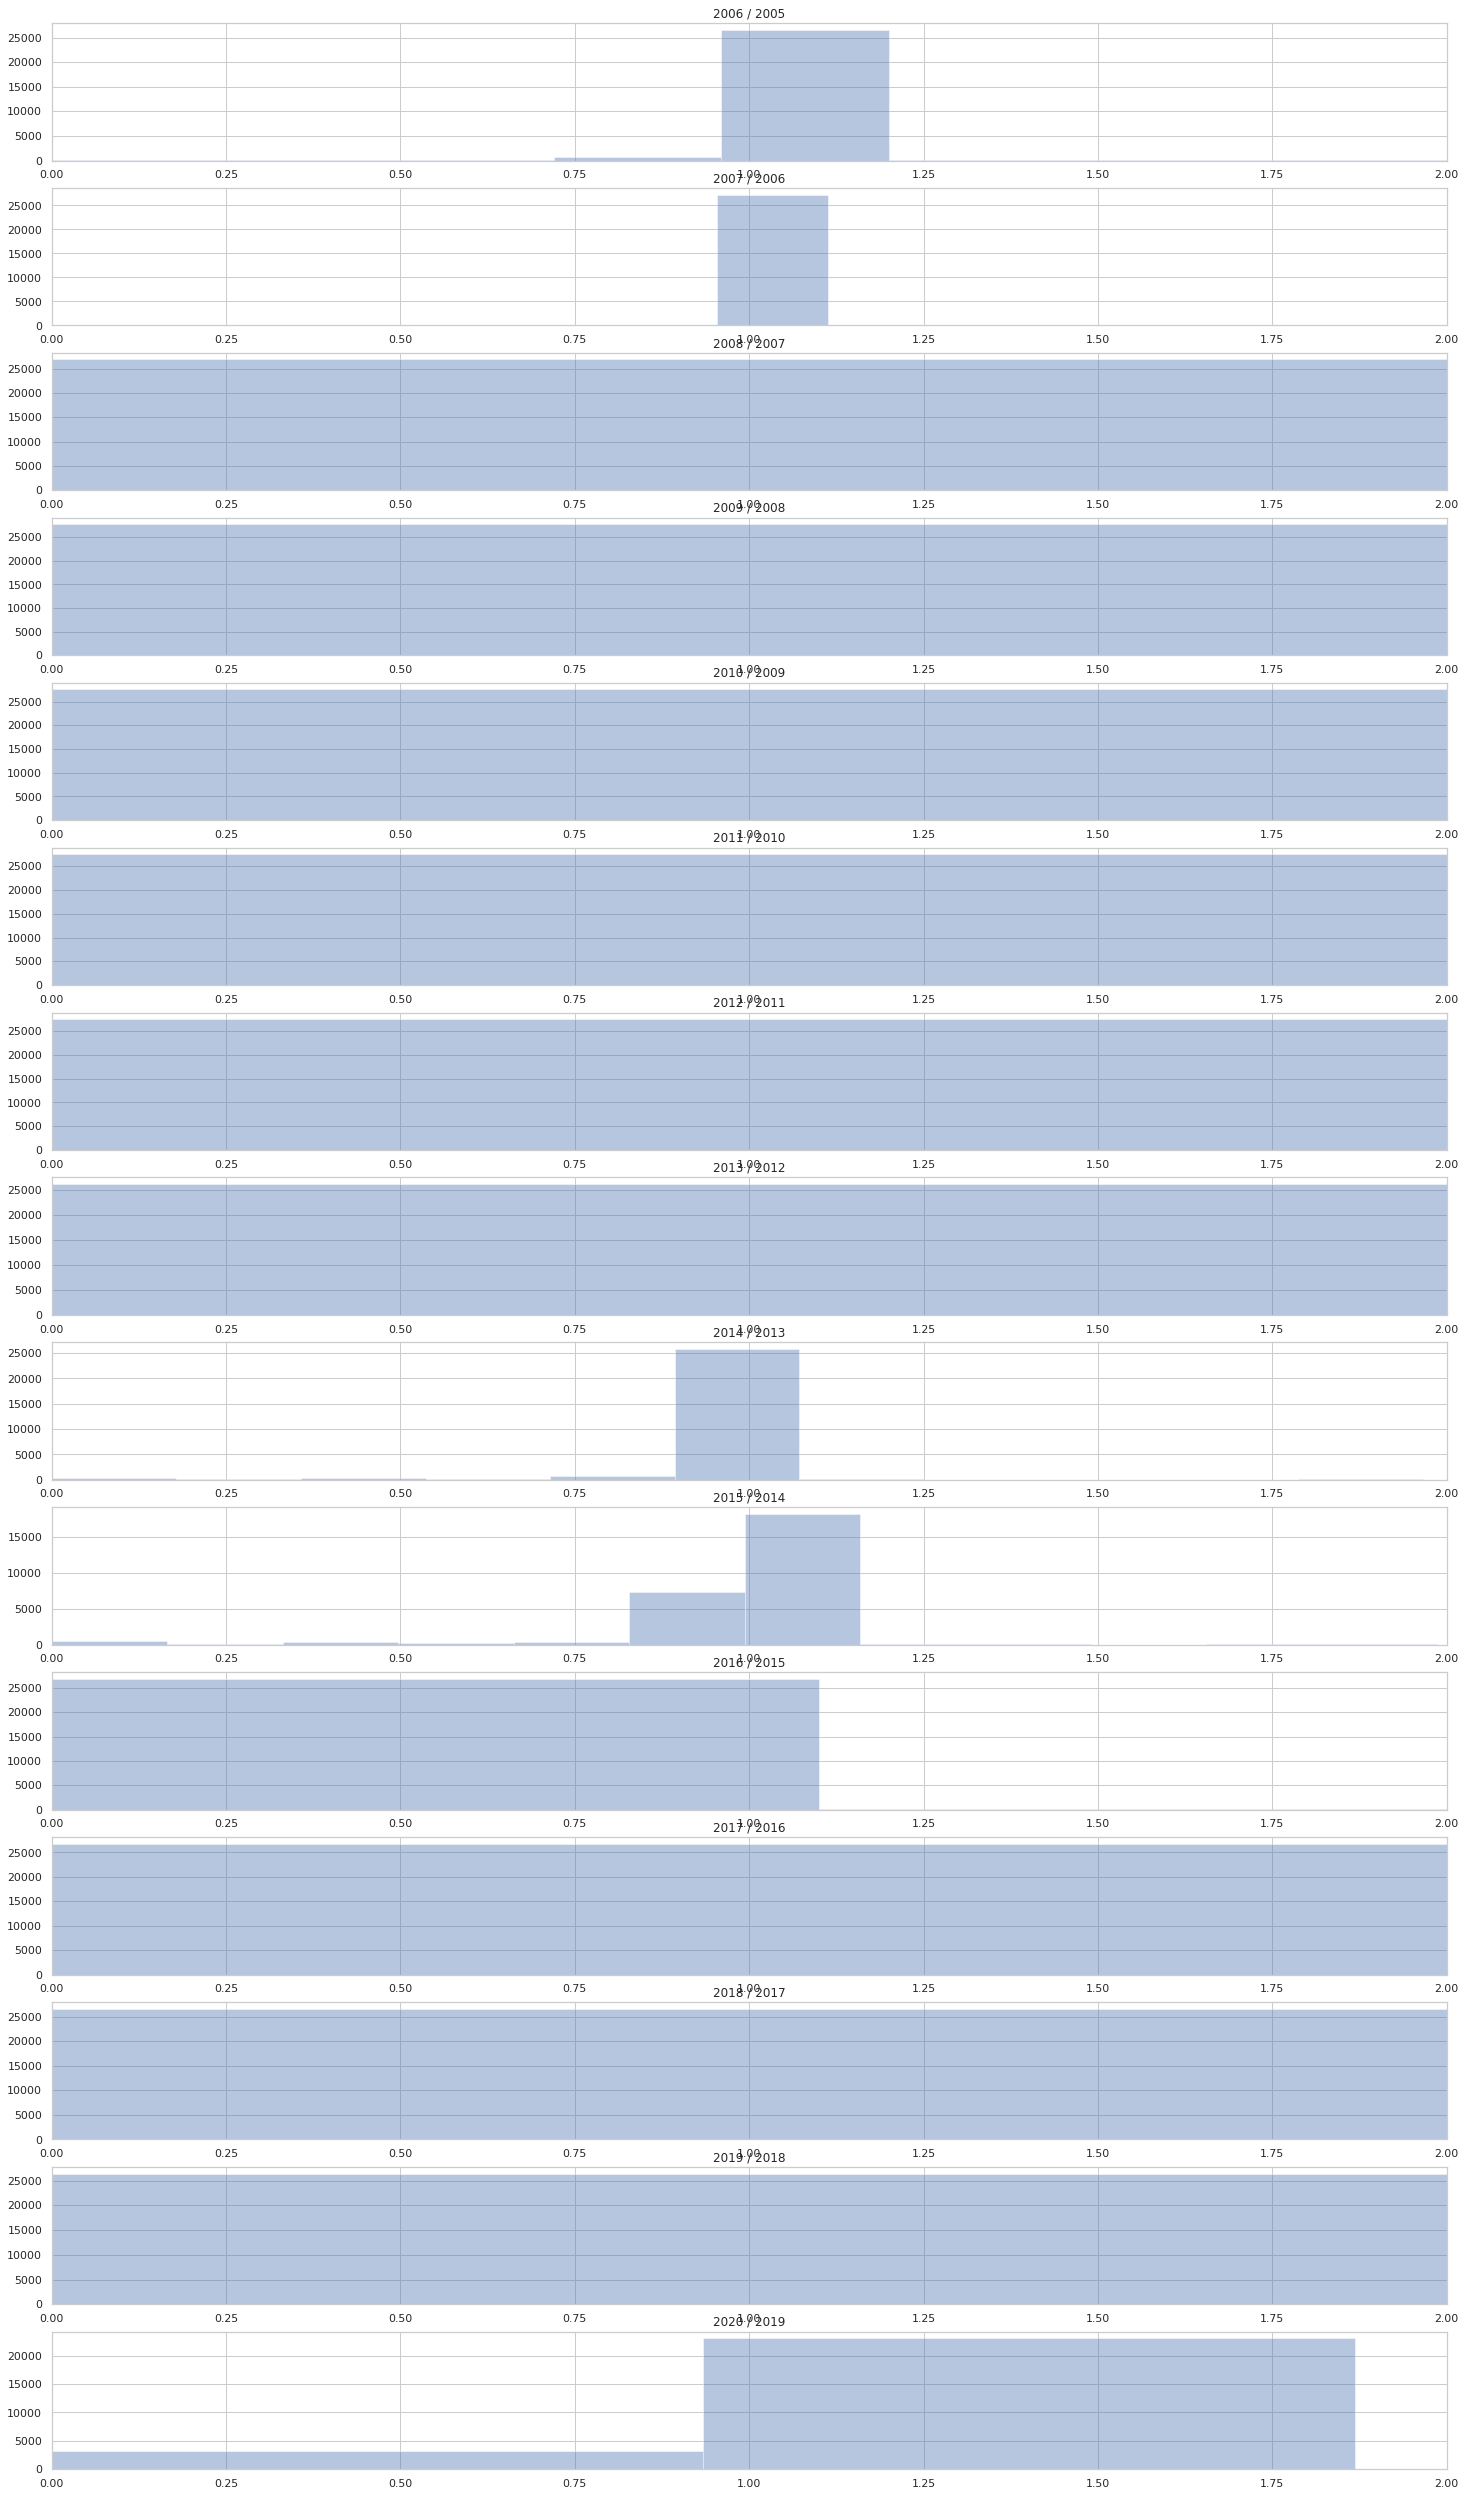

In [220]:
m, M = 2005, 2020
plt.figure(figsize=(25, (M - m) * 3))
for i, n in enumerate(range(2005, 2020)):
    ax = plt.subplot((M-m), 1, i+1, title='{} / {}'.format(n+1, n))
    dfs = dfj_compliance[dfj_compliance['year'] == n+1]['allowancesInAllocation'].reset_index() / dfj_compliance[dfj_compliance['year'] == n]['allowancesInAllocation'].reset_index()
    dfs.replace([np.inf, -np.inf], np.nan, inplace=True)
    ax.set_xlim([0,2])
    sns.distplot(
        dfs,
        ax=ax,
        kde=False
    )

## Allocations comparison to auctions

### Load auctions

In [265]:
df_auctions = pd.DataFrame()
YEARS = ['2017', '2018', '2019', '2020']

for year in YEARS:
    df_auctions = pd.concat([
        df_auctions,
        pd.read_excel('data/emission-spot-primary-market-auction-report-{}-data.xls'.format(year), skiprows=5)
    ])

### Sum auctions and allowances in allocation

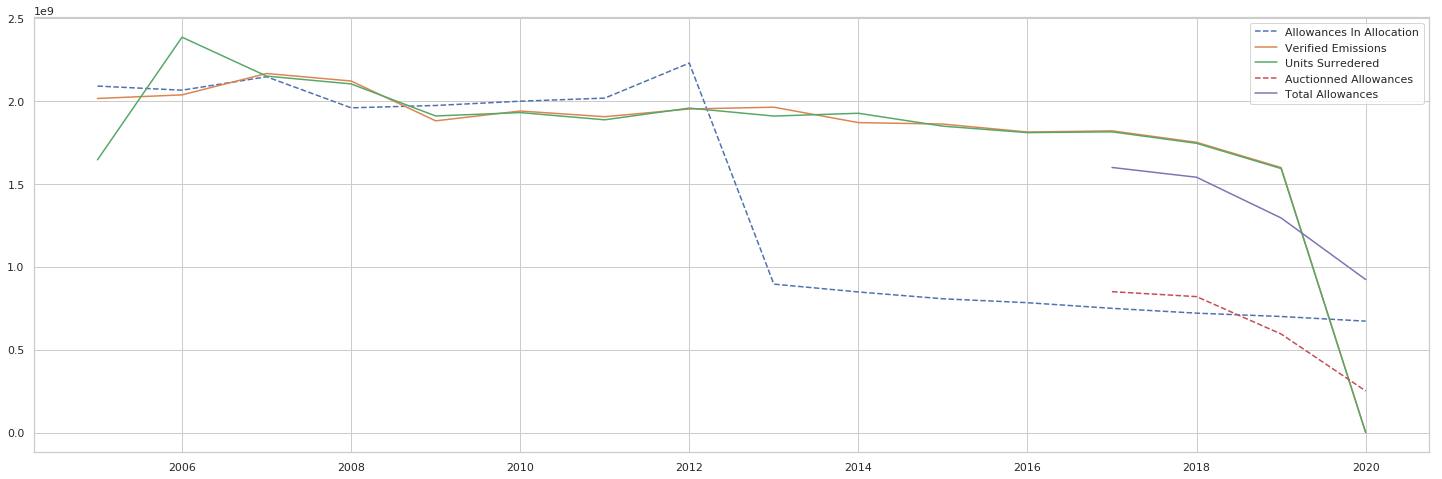

In [266]:
plt.figure(figsize=(25,8))
dfs = df_compliance.groupby('year').sum().reset_index()
dfs2 = pd.DataFrame(df_auctions.groupby(df_auctions['Time'].dt.year)['Auction Volume tCO2'].sum()).reset_index()
dfs3 = dfs.set_index('year')['allowancesInAllocation'] + dfs2.set_index('Time')['Auction Volume tCO2']
plt.plot('year', 'allowancesInAllocation', '--', data=dfs, label='Allowances In Allocation')
plt.plot('year', 'verifiedEmissionsProcessed', data=dfs, label='Verified Emissions')
plt.plot('year', 'unitsSurrenderedProcessed', data=dfs, label='Units Surredered')
plt.plot('Time', 'Auction Volume tCO2', '--', data=dfs2, label='Auctionned Allowances')
plt.plot(dfs3, label='Total Allowances')
plt.legend()